In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import optuna

In [9]:
df_weather_hourly = pd.read_parquet(r'..\data\01_interim\weather_hourly_darksky_cleaned.parquet')

In [10]:
df_consumption_hourly = pd.read_parquet(r'..\data\02_processed\parquet\group_4_half_hourly.parquet')

In [11]:
df_consumption_hourly = df_consumption_hourly.drop(columns=['Date','Acorn_grouped'])

In [12]:
def create_features(weather_df, consumption_df):
    if 'Date' in consumption_df.columns:
        consumption_df = consumption_df.drop(columns=['Date'])
    if 'Acorn_grouped' in consumption_df.columns:
        consumption_df = consumption_df.drop(columns=['Acorn_grouped'])
    df = pd.merge(weather_df, consumption_df, left_index=True, right_on='DateTime').reset_index(drop=True)
    df = df.drop(columns='apparentTemperature')
    holidays = pd.read_csv(r'..\data\00_raw\uk_bank_holidays.csv')
    holidays = pd.to_datetime(holidays['Bank holidays'])
    df['is_holiday'] = df['DateTime'].dt.date.isin(holidays.dt.date)
    df["hour"]      = df["DateTime"].dt.hour
    df["dayofweek"] = df["DateTime"].dt.dayofweek
    df["month"]     = df["DateTime"].dt.month
    df["dayofyear"] = df["DateTime"].dt.day_of_year
    df['is_holiday'] = df['is_holiday'].astype(int)

    return df

### Test set: last 48h

In [13]:
df = pd.merge(df_weather_hourly, df_consumption_hourly, left_index=True, right_on='DateTime').reset_index(drop=True)

In [14]:
df = df.drop(columns='apparentTemperature')

In [15]:
holidays = pd.read_csv(r'..\data\00_raw\uk_bank_holidays.csv')
holidays = pd.to_datetime(holidays['Bank holidays'])
df['is_holiday'] = df['DateTime'].dt.date.isin(holidays.dt.date)

In [16]:
df["hour"]      = df["DateTime"].dt.hour
df["dayofweek"] = df["DateTime"].dt.dayofweek
df["month"]     = df["DateTime"].dt.month
df["dayofyear"] = df["DateTime"].dt.day_of_year
df['is_holiday'] = df['is_holiday'].astype(int)

In [17]:
df = df.sort_values(["Acorn", "DateTime"]).reset_index(drop=True)
df["group_idx"] = df.groupby("Acorn").cumcount()

group_sizes = {
    ac: grp["group_idx"].max() + 1
    for ac, grp in df.groupby("Acorn")
}

# Mark the final 96 half‐hour rows (48h) of each ACORN as test
horizon_steps = 48 * 2  # 96 half‐hour rows
df["is_test"] = df.apply(
    lambda row: row["group_idx"] >= (group_sizes[row["Acorn"]] - horizon_steps),
    axis=1
)

# Split into df_train and df_test
df_train = df[df["is_test"] == False].copy()
df_test  = df[df["is_test"] == True].copy()

print(f"Total rows: {len(df)}")
print(f"Training rows: {len(df_train)}")
print(f"Test rows (96 × #ACORN): {len(df_test)}\n")

Total rows: 80796
Training rows: 80508
Test rows (96 × #ACORN): 288



In [18]:
numeric_features = [
    "visibility","windBearing","temperature","dewPoint","pressure",
    "windSpeed","humidity","hour","dayofweek","month",
    "dayofyear","is_holiday"
]
categorical_features = ["precipType","icon"]


=== Training Random Forest for ACORN = ACORN-C ===
  Train size = 26836, Test size = 96
  → Test RMSE = 0.0241, MAE = 0.0176, , MAPE = 1.7611 %

=== Training Random Forest for ACORN = ACORN-F ===
  Train size = 26836, Test size = 96
  → Test RMSE = 0.0170, MAE = 0.0135, , MAPE = 1.3513 %

=== Training Random Forest for ACORN = ACORN-P ===
  Train size = 26836, Test size = 96
  → Test RMSE = 0.0196, MAE = 0.0155, , MAPE = 1.5497 %

--- Feature Importances for ACORN = ACORN-C ---
  Top 10 features by importance:
    num__hour                       0.7321
    num__temperature                0.1455
    num__dayofyear                  0.0503
    num__dayofweek                  0.0121
    num__humidity                   0.0095
    num__pressure                   0.0085
    num__windSpeed                  0.0080
    cat__icon_partly-cloudy-day     0.0072
    num__visibility                 0.0065
    num__windBearing                0.0064


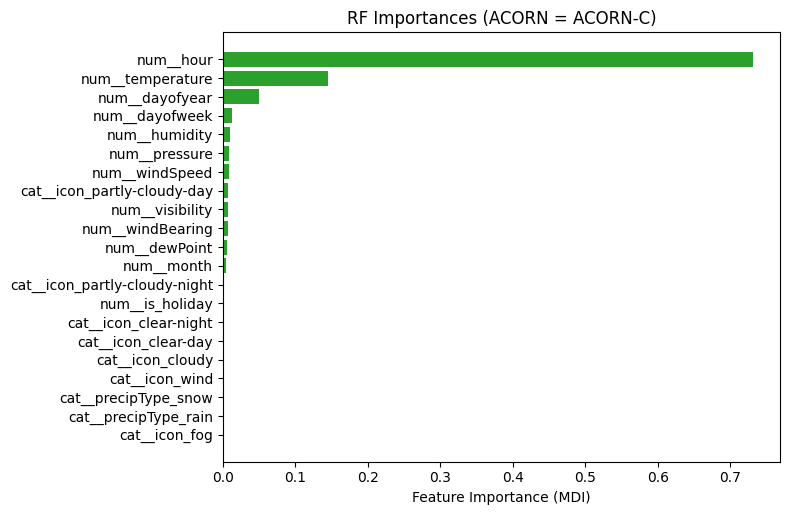

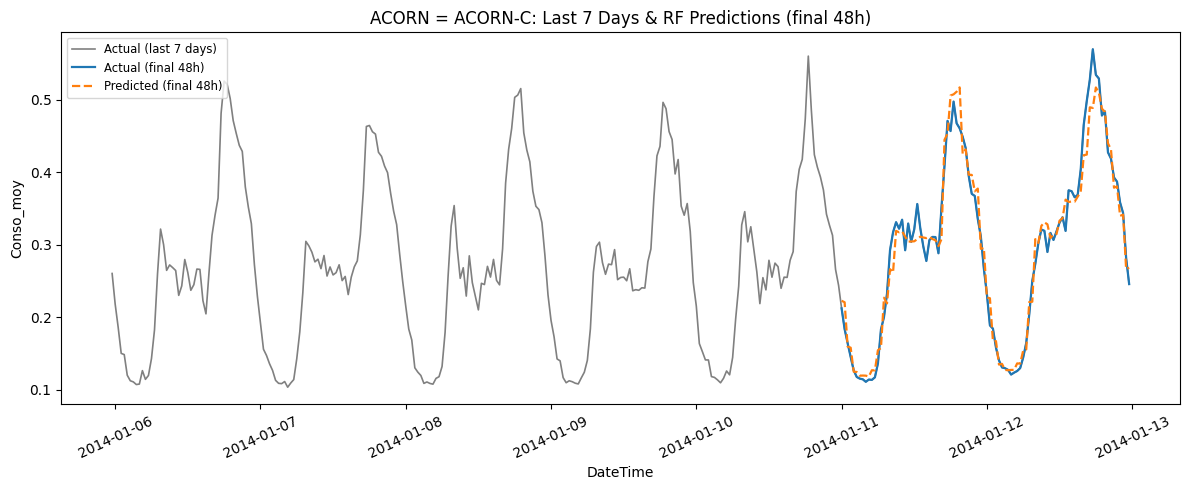


--- Feature Importances for ACORN = ACORN-F ---
  Top 10 features by importance:
    num__hour                       0.7044
    num__temperature                0.1888
    num__dayofyear                  0.0522
    num__dayofweek                  0.0193
    num__windSpeed                  0.0049
    num__pressure                   0.0046
    num__dewPoint                   0.0043
    num__month                      0.0043
    num__humidity                   0.0042
    num__visibility                 0.0041


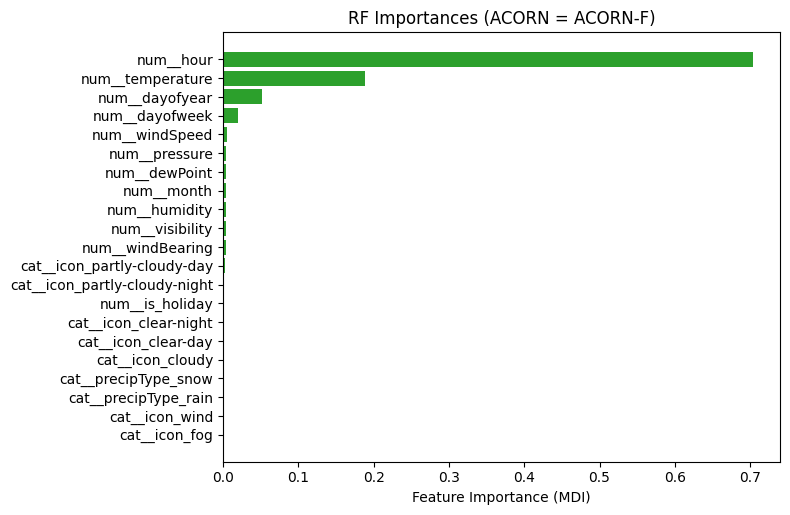

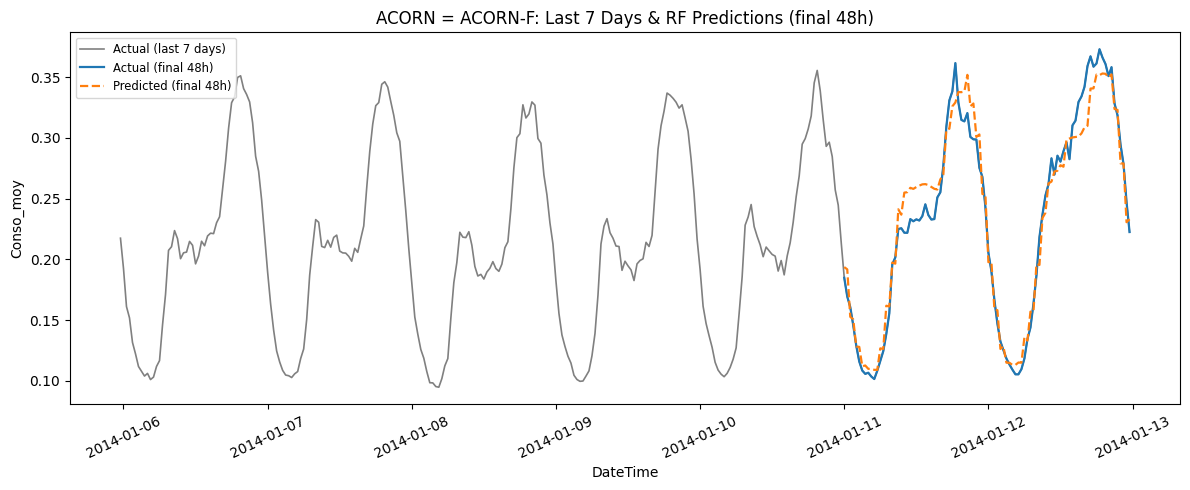


--- Feature Importances for ACORN = ACORN-P ---
  Top 10 features by importance:
    num__hour                       0.5935
    num__temperature                0.1709
    num__dayofyear                  0.1038
    num__pressure                   0.0209
    num__visibility                 0.0209
    num__windBearing                0.0200
    num__windSpeed                  0.0194
    num__dewPoint                   0.0181
    num__humidity                   0.0111
    num__dayofweek                  0.0078


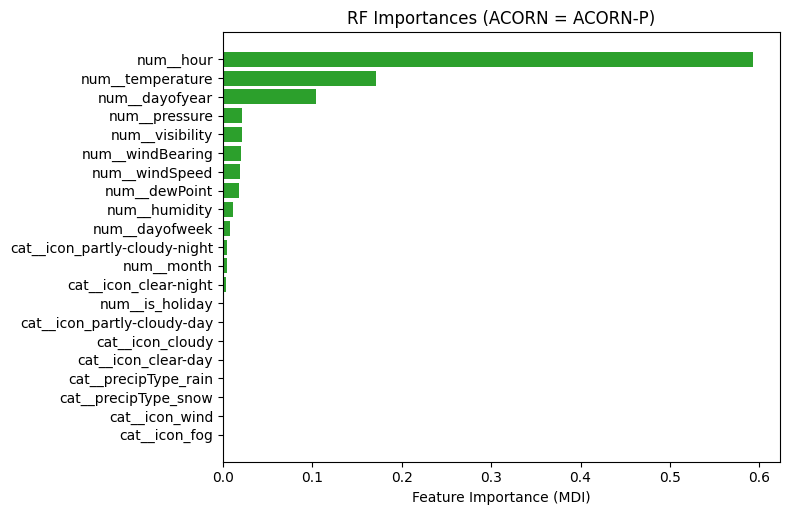

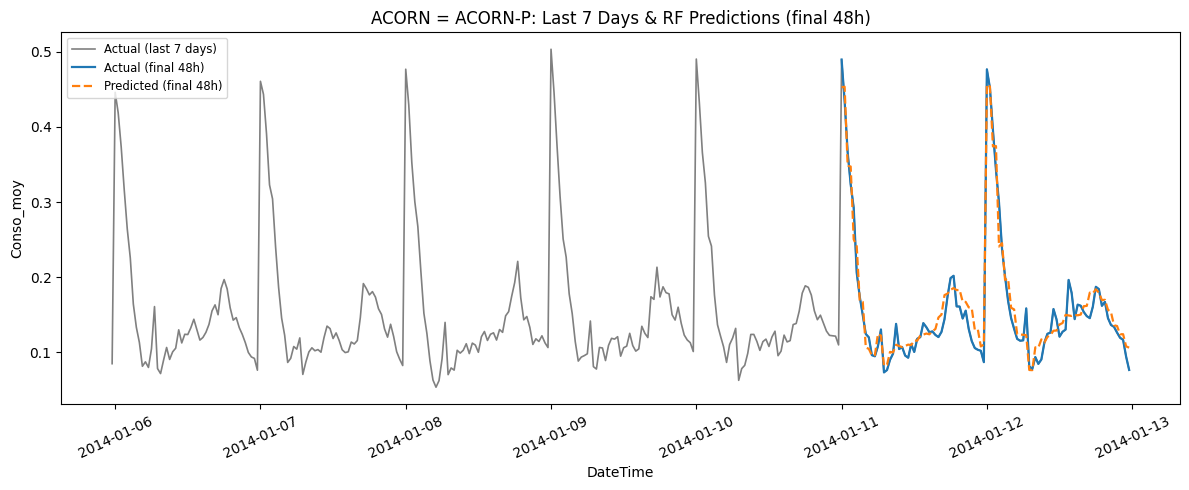

In [ ]:
results_rf = {}

for acorn_label in df_train["Acorn"].unique():
    print(f"\n=== Training Random Forest for ACORN = {acorn_label} ===")
    
    # Subset this ACORN’s train/test
    sub_train = df_train[df_train["Acorn"] == acorn_label].copy().reset_index(drop=True)
    sub_test  = df_test [df_test ["Acorn"] == acorn_label].copy().reset_index(drop=True)
    
    # Extract X_train_sub, y_train_sub, X_test_sub, y_test_sub
    y_train_sub = sub_train["Conso_moy"].astype(float)
    y_test_sub  = sub_test ["Conso_moy"].astype(float)
    
    drop_cols = ["Conso_moy","group_idx","is_test","Acorn","DateTime"]
    X_train_sub = sub_train.drop(columns=drop_cols)
    X_test_sub  = sub_test .drop(columns=drop_cols)
    
    print(f"  Train size = {len(X_train_sub)}, Test size = {len(X_test_sub)}")
    
    # Build ColumnTransformer (no “Acorn” in categorical_features)
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop"
    )
    
    # Build Pipeline: Preprocessor → RandomForest
    rf = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    pipe = Pipeline([
        ("preproc", preprocessor),
        ("rf", rf),
    ])
    
    # Fit on this ACORN’s training data
    pipe.fit(X_train_sub, y_train_sub)
    
    # Predict on this ACORN’s test set (final 48h)
    y_pred_sub = pipe.predict(X_test_sub)
    
    # Compute RMSE / MAE on held‐out 48h
    rmse_sub = np.sqrt(mean_squared_error(y_test_sub, y_pred_sub))
    mae_sub  = mean_absolute_error(y_test_sub, y_pred_sub)
    mape_sub  = mean_absolute_percentage_error(y_test_sub, y_pred_sub)
    print(f"  → Test RMSE = {rmse_sub:.4f}, MAE = {mae_sub:.4f}, , MAPE = {100*mae_sub:.4f} %")
    
    # Store results
    results_rf[acorn_label] = {
        "pipeline":   pipe,
        "X_test_sub": X_test_sub,
        "y_test_sub": y_test_sub.values,
        "y_pred_sub": y_pred_sub,
        "df_test_sub": sub_test,
    }

# ──────────────────────────────────────────────────────────────────────────────
# FEATURE IMPORTANCE AND PLOTTING LAST 7 DAYS PER ACORN
# ──────────────────────────────────────────────────────────────────────────────
for acorn_label, info in results_rf.items():
    # FEATURE IMPORTANCE
    print(f"\n--- Feature Importances for ACORN = {acorn_label} ---")
    pipe    = info["pipeline"]
    preproc = pipe.named_steps["preproc"]
    rf_mod  = pipe.named_steps["rf"]
    
    # Retrieve post-transform feature names
    feature_names = preproc.get_feature_names_out()
    importances   = rf_mod.feature_importances_
    idx_sorted    = np.argsort(importances)[::-1]
    
    print("  Top 10 features by importance:")
    for i in idx_sorted[:10]:
        print(f"    {feature_names[i]:<30}  {importances[i]:0.4f}")
    
    # Plot all importances
    n_features = len(feature_names)
    plt.figure(figsize=(8, n_features * 0.25))
    plt.barh(
        np.arange(n_features),
        importances[idx_sorted],
        align="center",
        color="C2"
    )
    plt.yticks(np.arange(n_features), feature_names[idx_sorted])
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance (MDI)")
    plt.title(f"RF Importances (ACORN = {acorn_label})")
    plt.tight_layout()
    plt.show()
    
    # PLOT LAST 7 DAYS WITH FINAL 48h PREDICTIONS
    full_group    = df[df["Acorn"] == acorn_label].sort_values("DateTime").reset_index(drop=True)
    last_timestamp = full_group["DateTime"].max()
    one_week_ago   = last_timestamp - pd.Timedelta(days=7)
    last_week_df   = full_group[full_group["DateTime"] >= one_week_ago].reset_index(drop=True)
    
    sub_test = info["df_test_sub"].sort_values("DateTime").reset_index(drop=True)
    y_pred   = info["y_pred_sub"]
    
    plt.figure(figsize=(12, 5))
    # Actual last 7 days (gray)
    plt.plot(
        last_week_df["DateTime"],
        last_week_df["Conso_moy"],
        label="Actual (last 7 days)",
        color="gray",
        linewidth=1.2
    )
    # Actual final 48h (blue)
    plt.plot(
        sub_test["DateTime"],
        sub_test["Conso_moy"],
        label="Actual (final 48h)",
        color="C0",
        linewidth=1.6
    )
    # Predicted final 48h (dashed orange)
    plt.plot(
        sub_test["DateTime"],
        y_pred,
        label="Predicted (final 48h)",
        color="C1",
        linestyle="--",
        linewidth=1.6
    )
    plt.xlabel("DateTime")
    plt.ylabel("Conso_moy")
    plt.title(f"ACORN = {acorn_label}: Last 7 Days & RF Predictions (final 48h)")
    plt.legend(loc="upper left", fontsize="small")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

### Test set: last week

In [115]:
# ──────────────────────────────────────────────────────────────────────────────
df = pd.merge(df_weather_hourly, df_consumption_hourly, left_index=True, right_on='DateTime').reset_index(drop=True)

# Extract hour, day of week, month, and day of year
df["hour"]      = df["DateTime"].dt.hour
df["dayofweek"] = df["DateTime"].dt.dayofweek
df["month"]     = df["DateTime"].dt.month
df["dayofyear"] = df["DateTime"].dt.dayofyear
df = df.drop(columns='apparentTemperature')
df['is_holiday'] = df['DateTime'].dt.date.isin(holidays.dt.date)


# ──────────────────────────────────────────────────────────────────────────────
# SORT BY ACORN & DATETIME, ASSIGN WITHIN‐GROUP INDEX, AND SPLIT FINAL WEEK AS TEST
# ──────────────────────────────────────────────────────────────────────────────
df = df.sort_values(["Acorn", "DateTime"]).reset_index(drop=True)
df["group_idx"] = df.groupby("Acorn").cumcount()

# Compute each ACORN group’s size
group_sizes = {
    ac: grp["group_idx"].max() + 1
    for ac, grp in df.groupby("Acorn")
}

# Mark the final week (7 days = 7*48 half‐hour rows = 336) of each ACORN as test
horizon_steps = 7 * 48  # 336 half‐hour rows
df["is_test"] = df.apply(
    lambda row: row["group_idx"] >= (group_sizes[row["Acorn"]] - horizon_steps),
    axis=1
)

# Split into df_train and df_test
df_train = df[df["is_test"] == False].copy()
df_test  = df[df["is_test"] == True].copy()

print(f"Total rows: {len(df)}")
print(f"Training rows: {len(df_train)}")
print(f"Test rows (336 × #ACORN): {len(df_test)}\n")

# ──────────────────────────────────────────────────────────────────────────────
# DEFINE FEATURE COLUMNS
# ──────────────────────────────────────────────────────────────────────────────
numeric_features = [
    "visibility","windBearing","temperature","dewPoint","pressure",
    "windSpeed","humidity","hour","dayofweek","month",
    "dayofyear","is_holiday"
]
categorical_features = ["precipType","icon"]

# ──────────────────────────────────────────────────────────────────────────────
# LOOP OVER EACH ACORN TO TRAIN A RF WITH DEFAULT HYPERPARAMETERS
# ──────────────────────────────────────────────────────────────────────────────
results_rf = {}

for acorn_label in df_train["Acorn"].unique():
    print(f"\n=== Training Random Forest for ACORN = {acorn_label} ===")
    
    # Subset this ACORN’s train/test
    sub_train = df_train[df_train["Acorn"] == acorn_label].copy().reset_index(drop=True)
    sub_test  = df_test [df_test ["Acorn"] == acorn_label].copy().reset_index(drop=True)
    
    # Extract X_train_sub, y_train_sub, X_test_sub, y_test_sub
    y_train_sub = sub_train["Conso_moy"].astype(float)
    y_test_sub  = sub_test ["Conso_moy"].astype(float)
    
    drop_cols = ["Conso_moy","group_idx","is_test","Acorn","DateTime"]
    X_train_sub = sub_train.drop(columns=drop_cols)
    X_test_sub  = sub_test .drop(columns=drop_cols)
    
    print(f"  Train size = {len(X_train_sub)}, Test size = {len(X_test_sub)}")
    
    # Build ColumnTransformer (no “Acorn” in categorical_features)
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop"
    )
    
    # Build Pipeline: Preprocessor → RandomForest
    rf = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    pipe = Pipeline([
        ("preproc", preprocessor),
        ("rf", rf),
    ])
    
    # Fit on this ACORN’s training data
    pipe.fit(X_train_sub, y_train_sub)
    
    # Predict on this ACORN’s test set (final week)
    y_pred_sub = pipe.predict(X_test_sub)
    
    # Compute RMSE / MAE on held‐out week
    rmse_sub = np.sqrt(mean_squared_error(y_test_sub, y_pred_sub))
    mae_sub  = mean_absolute_error(y_test_sub, y_pred_sub)
    print(f"  → Test RMSE = {rmse_sub:.4f}, MAE = {mae_sub:.4f}")
    
    # Store results
    results_rf[acorn_label] = {
        "pipeline":   pipe,
        "X_test_sub": X_test_sub,
        "y_test_sub": y_test_sub.values,
        "y_pred_sub": y_pred_sub,
        "df_test_sub": sub_test,
    }

# ──────────────────────────────────────────────────────────────────────────────
# FEATURE IMPORTANCE AND PLOTTING LAST WEEK PER ACORN
# ──────────────────────────────────────────────────────────────────────────────
for acorn_label, info in results_rf.items():
    # FEATURE IMPORTANCE
    print(f"\n--- Feature Importances for ACORN = {acorn_label} ---")
    pipe    = info["pipeline"]
    preproc = pipe.named_steps["preproc"]
    rf_mod  = pipe.named_steps["rf"]
    
    # Retrieve post-transform feature names
    feature_names = preproc.get_feature_names_out()
    importances   = rf_mod.feature_importances_
    idx_sorted    = np.argsort(importances)[::-1]
    
    print("  Top 10 features by importance:")
    for i in idx_sorted[:10]:
        print(f"    {feature_names[i]:<30}  {importances[i]:0.4f}")
    
    # Plot all importances
    n_features = len(feature_names)
    plt.figure(figsize=(8, n_features * 0.25))
    plt.barh(
        np.arange(n_features),
        importances[idx_sorted],
        align="center",
        color="C2"
    )
    plt.yticks(np.arange(n_features), feature_names[idx_sorted])
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance (MDI)")
    plt.title(f"RF Importances (ACORN = {acorn_label})")
    plt.tight_layout()
    plt.show()
    
    # PLOT LAST WEEK WITH FINAL WEEK’S PREDICTIONS
    full_group    = df[df["Acorn"] == acorn_label].sort_values("DateTime").reset_index(drop=True)
    last_timestamp = full_group["DateTime"].max()
    one_week_ago   = last_timestamp - pd.Timedelta(days=7)
    last_week_df   = full_group[full_group["DateTime"] >= one_week_ago].reset_index(drop=True)
    
    sub_test = info["df_test_sub"].sort_values("DateTime").reset_index(drop=True)
    y_pred   = info["y_pred_sub"]
    
    plt.figure(figsize=(12, 5))
    # Actual last week (light gray)
    plt.plot(
        last_week_df["DateTime"],
        last_week_df["Conso_moy"],
        label="Actual (last week)",
        color="lightgray",
        linewidth=1.2
    )
    # Actual final week (blue)
    plt.plot(
        sub_test["DateTime"],
        sub_test["Conso_moy"],
        label="Actual (final week)",
        color="C0",
        linewidth=1.6
    )
    # Predicted final week (dashed orange)
    plt.plot(
        sub_test["DateTime"],
        y_pred,
        label="Predicted (final week)",
        color="C1",
        linestyle="--",
        linewidth=1.6
    )
    plt.xlabel("DateTime")
    plt.ylabel("Conso_moy")
    plt.title(f"ACORN = {acorn_label}: Last Week of Actual & RF Predictions (final week)")
    plt.legend(loc="upper left", fontsize="small")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()


Total rows: 80796
Training rows: 79788
Test rows (336 × #ACORN): 1008


=== Training Random Forest for ACORN = ACORN-C ===
  Train size = 26596, Test size = 336
  → Test RMSE = 0.0261, MAE = 0.0197

=== Training Random Forest for ACORN = ACORN-F ===
  Train size = 26596, Test size = 336
  → Test RMSE = 0.0148, MAE = 0.0118

=== Training Random Forest for ACORN = ACORN-P ===
  Train size = 26596, Test size = 336


KeyboardInterrupt: 

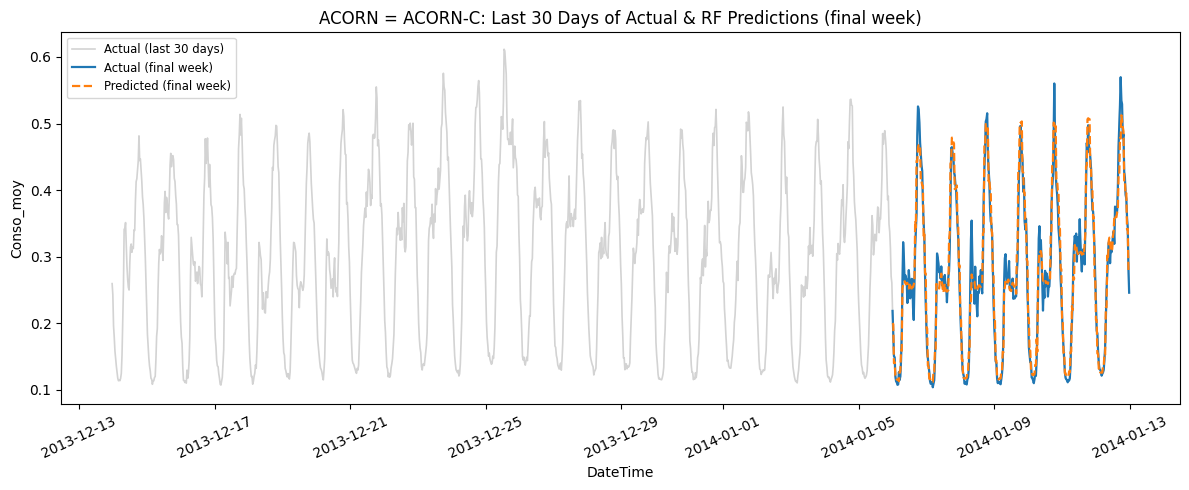

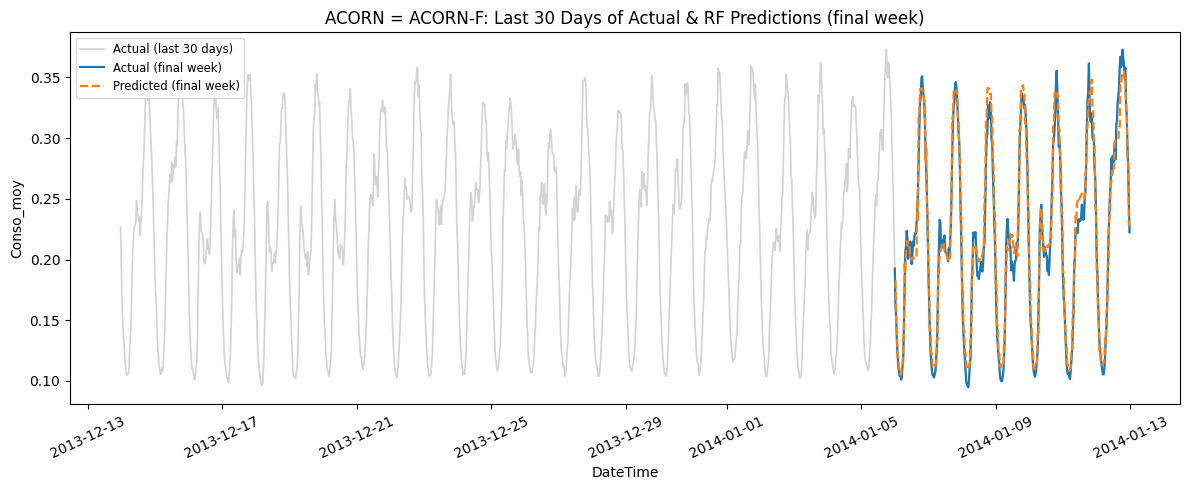

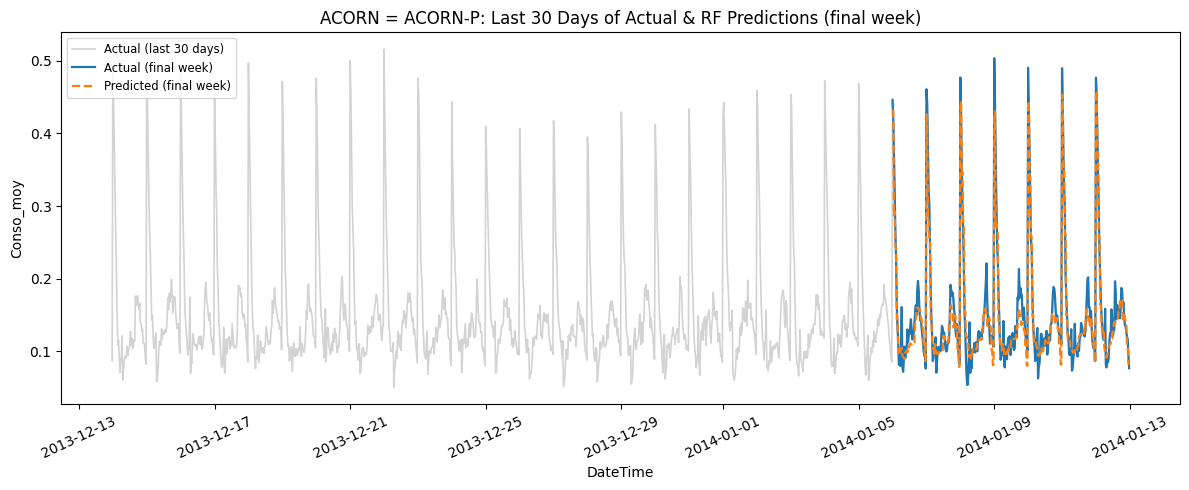

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# Plot the last month of actual consumption and overlay the final week’s RF predictions
# ──────────────────────────────────────────────────────────────────────────────

for acorn_label, info in results_rf.items():
    # 1) Full history for this ACORN, sorted by DateTime
    full_group    = df[df["Acorn"] == acorn_label].sort_values("DateTime").reset_index(drop=True)
    last_timestamp = full_group["DateTime"].max()
    
    # 2) Compute one month ago (30 days)
    one_month_ago = last_timestamp - pd.Timedelta(days=30)
    
    # 3) Filter to only the last 30 days of actual consumption
    last_month_df = full_group[full_group["DateTime"] >= one_month_ago].reset_index(drop=True)
    
    # 4) Extract the final week test subset and its predictions
    sub_test = info["df_test_sub"].sort_values("DateTime").reset_index(drop=True)
    y_pred   = info["y_pred_sub"]
    
    # 5) Plot
    plt.figure(figsize=(12, 5))
    
    # 5A) Last 30 days actual (light gray)
    plt.plot(
        last_month_df["DateTime"],
        last_month_df["Conso_moy"],
        label="Actual (last 30 days)",
        color="lightgray",
        linewidth=1.2
    )
    
    # 5B) Actual final week (solid blue)
    plt.plot(
        sub_test["DateTime"],
        sub_test["Conso_moy"],
        label="Actual (final week)",
        color="C0",
        linewidth=1.6
    )
    
    # 5C) RF predicted final week (dashed orange)
    plt.plot(
        sub_test["DateTime"],
        y_pred,
        label="Predicted (final week)",
        color="C1",
        linestyle="--",
        linewidth=1.6
    )
    
    plt.xlabel("DateTime")
    plt.ylabel("Conso_moy")
    plt.title(f"ACORN = {acorn_label}: Last 30 Days of Actual & RF Predictions (final week)")
    plt.legend(loc="upper left", fontsize="small")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()


### Hyperparameter tuning

In [19]:
results_rf = {}

for acorn_label in df_train["Acorn"].unique():
    print(f"\n=== TUNING & TRAINING RF FOR ACORN = {acorn_label} ===")
    
    # Subset this ACORN’s train/test
    sub_train = df_train[df_train["Acorn"] == acorn_label].copy().reset_index(drop=True)
    sub_test  = df_test [df_test ["Acorn"] == acorn_label].copy().reset_index(drop=True)
    
    # Extract X_train_sub, y_train_sub, X_test_sub, y_test_sub
    y_train_sub = sub_train["Conso_moy"].astype(float)
    y_test_sub  = sub_test ["Conso_moy"].astype(float)
    
    drop_cols = ["Conso_moy","group_idx","is_test","Acorn","DateTime"]
    X_train_sub = sub_train.drop(columns=drop_cols)
    X_test_sub  = sub_test .drop(columns=drop_cols)
    
    print(f"  Train size = {len(X_train_sub)}, Test size = {len(X_test_sub)}")
    
    # Build ColumnTransformer (no “Acorn”)
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop"
    )
    
    # Define Optuna objective for this ACORN
    def objective(trial):
        n_estimators     = trial.suggest_int("n_estimators", 50, 300)
        max_depth        = trial.suggest_int("max_depth", 5, 30)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
        min_samples_leaf  = trial.suggest_int("min_samples_leaf", 1, 10)
        max_features     = trial.suggest_categorical("max_features", ["sqrt","log2",None])
        
        rf = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
        )
        pipe = Pipeline([
            ("preproc", preprocessor),
            ("rf", rf),
        ])
        
        tscv = TimeSeriesSplit(n_splits=3)
        neg_rmse = cross_val_score(
            pipe,
            X_train_sub,
            y_train_sub,
            cv=tscv,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1
        )
        # cross_val_score returns negative RMSE; convert to positive
        rmse_scores = -neg_rmse
        return float(rmse_scores.mean())
    
    # Run Optuna search for this ACORN
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50, n_jobs=6, show_progress_bar=True)
    
    best_params = study.best_params
    print(f"  → Best params: {best_params}")
    print(f"  → Best CV‐RMSE = {study.best_value:.4f}")
    
    # Rebuild pipeline with best hyperparameters
    best_rf = RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"],
        max_features=best_params["max_features"],
        random_state=42,
        n_jobs=-1
    )
    best_pipe = Pipeline([
        ("preproc", preprocessor),
        ("rf", best_rf),
    ])
    
    # Fit on full train subset for this ACORN
    best_pipe.fit(X_train_sub, y_train_sub)
    
    # Predict on test subset (final week)
    y_pred_sub = best_pipe.predict(X_test_sub)
    
    # Compute RMSE / MAE on held‐out week
    rmse_sub = np.sqrt(mean_squared_error(y_test_sub, y_pred_sub))
    mae_sub  = mean_absolute_error(y_test_sub, y_pred_sub)
    mape_sub  = mean_absolute_percentage_error(y_test_sub, y_pred_sub)
    print(f"  → Held‐out week Test RMSE = {rmse_sub:.4f}, MAE = {mae_sub:.4f}, MAPE = {100*mape_sub:.4f} %")
    
    # Store results
    results_rf[acorn_label] = {
        "best_params":  best_params,
        "cv_rmse":      study.best_value,
        "test_rmse":    rmse_sub,
        "test_mae":     mae_sub,
        "pipeline":     best_pipe,
        "X_test_sub":   X_test_sub,
        "y_test_sub":   y_test_sub.values,
        "y_pred_sub":   y_pred_sub,
        "df_test_sub":  sub_test,
    }


[I 2025-06-06 12:29:40,798] A new study created in memory with name: no-name-43b5d197-3895-426a-9e21-f3a65a8c8aae



=== TUNING & TRAINING RF FOR ACORN = ACORN-C ===
  Train size = 26836, Test size = 96


Best trial: 1. Best value: 0.055705:   4%|▍         | 2/50 [00:06<02:06,  2.64s/it] 

[I 2025-06-06 12:29:47,041] Trial 0 finished with value: 0.05591862965386996 and parameters: {'n_estimators': 132, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.05591862965386996.
[I 2025-06-06 12:29:47,167] Trial 1 finished with value: 0.05570502858207949 and parameters: {'n_estimators': 258, 'max_depth': 30, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 0.05570502858207949.


Best trial: 1. Best value: 0.055705:   6%|▌         | 3/50 [00:11<02:47,  3.57s/it]

[I 2025-06-06 12:29:51,828] Trial 3 finished with value: 0.05931454113201071 and parameters: {'n_estimators': 158, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.05570502858207949.


Best trial: 4. Best value: 0.0556284:  12%|█▏        | 6/50 [00:11<00:52,  1.20s/it]

[I 2025-06-06 12:29:52,563] Trial 2 finished with value: 0.05596225024352103 and parameters: {'n_estimators': 171, 'max_depth': 17, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.05570502858207949.
[I 2025-06-06 12:29:52,645] Trial 5 finished with value: 0.055769986318149854 and parameters: {'n_estimators': 183, 'max_depth': 28, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.05570502858207949.
[I 2025-06-06 12:29:52,760] Trial 4 finished with value: 0.05562836712493421 and parameters: {'n_estimators': 214, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.05562836712493421.


Best trial: 6. Best value: 0.0476803:  14%|█▍        | 7/50 [00:13<00:59,  1.38s/it]

[I 2025-06-06 12:29:54,612] Trial 6 finished with value: 0.04768030065040852 and parameters: {'n_estimators': 84, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 6 with value: 0.04768030065040852.


Best trial: 6. Best value: 0.0476803:  16%|█▌        | 8/50 [00:15<01:04,  1.53s/it]

[I 2025-06-06 12:29:56,510] Trial 7 finished with value: 0.056675225867839706 and parameters: {'n_estimators': 220, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 6 with value: 0.04768030065040852.


Best trial: 6. Best value: 0.0476803:  18%|█▊        | 9/50 [00:21<01:52,  2.75s/it]

[I 2025-06-06 12:30:02,292] Trial 9 finished with value: 0.060645897387966545 and parameters: {'n_estimators': 253, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 6 with value: 0.04768030065040852.


Best trial: 6. Best value: 0.0476803:  20%|██        | 10/50 [00:22<01:27,  2.19s/it]

[I 2025-06-06 12:30:03,114] Trial 10 finished with value: 0.055085319857206265 and parameters: {'n_estimators': 220, 'max_depth': 28, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 6 with value: 0.04768030065040852.


Best trial: 6. Best value: 0.0476803:  22%|██▏       | 11/50 [00:27<02:03,  3.17s/it]

[I 2025-06-06 12:30:08,639] Trial 12 finished with value: 0.05606801434256319 and parameters: {'n_estimators': 82, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 6 with value: 0.04768030065040852.


Best trial: 8. Best value: 0.0464809:  24%|██▍       | 12/50 [00:28<01:31,  2.42s/it]

[I 2025-06-06 12:30:09,271] Trial 8 finished with value: 0.04648089040210557 and parameters: {'n_estimators': 224, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 8 with value: 0.04648089040210557.


Best trial: 8. Best value: 0.0464809:  26%|██▌       | 13/50 [00:29<01:12,  1.97s/it]

[I 2025-06-06 12:30:10,141] Trial 11 finished with value: 0.04663335061065707 and parameters: {'n_estimators': 117, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 8 with value: 0.04648089040210557.


Best trial: 8. Best value: 0.0464809:  28%|██▊       | 14/50 [00:31<01:09,  1.92s/it]

[I 2025-06-06 12:30:11,993] Trial 13 finished with value: 0.04878657133282088 and parameters: {'n_estimators': 116, 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 8 with value: 0.04648089040210557.


Best trial: 8. Best value: 0.0464809:  30%|███       | 15/50 [00:32<01:01,  1.77s/it]

[I 2025-06-06 12:30:13,397] Trial 14 finished with value: 0.0544972990564224 and parameters: {'n_estimators': 154, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.04648089040210557.


Best trial: 8. Best value: 0.0464809:  32%|███▏      | 16/50 [00:35<01:13,  2.16s/it]

[I 2025-06-06 12:30:16,478] Trial 15 finished with value: 0.046840310872901296 and parameters: {'n_estimators': 61, 'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 8 with value: 0.04648089040210557.


Best trial: 8. Best value: 0.0464809:  34%|███▍      | 17/50 [00:36<00:57,  1.73s/it]

[I 2025-06-06 12:30:17,209] Trial 16 finished with value: 0.04678175068711185 and parameters: {'n_estimators': 53, 'max_depth': 25, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 8 with value: 0.04648089040210557.


Best trial: 8. Best value: 0.0464809:  36%|███▌      | 18/50 [00:40<01:13,  2.30s/it]

[I 2025-06-06 12:30:20,846] Trial 17 finished with value: 0.0468666354639499 and parameters: {'n_estimators': 52, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 8 with value: 0.04648089040210557.


Best trial: 18. Best value: 0.0460622:  38%|███▊      | 19/50 [01:48<11:26, 22.16s/it]

[I 2025-06-06 12:31:29,322] Trial 18 finished with value: 0.046062224864688604 and parameters: {'n_estimators': 298, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 18 with value: 0.046062224864688604.


Best trial: 18. Best value: 0.0460622:  40%|████      | 20/50 [01:50<08:03, 16.12s/it]

[I 2025-06-06 12:31:31,287] Trial 20 finished with value: 0.046112601756217654 and parameters: {'n_estimators': 281, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 18 with value: 0.046062224864688604.


Best trial: 18. Best value: 0.0460622:  42%|████▏     | 21/50 [02:05<07:40, 15.87s/it]

[I 2025-06-06 12:31:46,619] Trial 19 finished with value: 0.046062224864688604 and parameters: {'n_estimators': 298, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 18 with value: 0.046062224864688604.


Best trial: 18. Best value: 0.0460622:  44%|████▍     | 22/50 [02:08<05:32, 11.86s/it]

[I 2025-06-06 12:31:49,167] Trial 21 finished with value: 0.04618070626964155 and parameters: {'n_estimators': 297, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 18 with value: 0.046062224864688604.


Best trial: 18. Best value: 0.0460622:  46%|████▌     | 23/50 [03:27<14:23, 31.98s/it]

[I 2025-06-06 12:33:08,159] Trial 22 finished with value: 0.04619671898436081 and parameters: {'n_estimators': 284, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 18 with value: 0.046062224864688604.


Best trial: 18. Best value: 0.0460622:  48%|████▊     | 24/50 [03:33<10:31, 24.28s/it]

[I 2025-06-06 12:33:14,481] Trial 23 finished with value: 0.04648255613420821 and parameters: {'n_estimators': 294, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 18 with value: 0.046062224864688604.


Best trial: 18. Best value: 0.0460622:  50%|█████     | 25/50 [03:44<08:26, 20.26s/it]

[I 2025-06-06 12:33:25,339] Trial 24 finished with value: 0.04622735302753558 and parameters: {'n_estimators': 297, 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 18 with value: 0.046062224864688604.


Best trial: 18. Best value: 0.0460622:  52%|█████▏    | 26/50 [03:46<05:55, 14.81s/it]

[I 2025-06-06 12:33:27,426] Trial 25 finished with value: 0.04626110377513284 and parameters: {'n_estimators': 293, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 18 with value: 0.046062224864688604.


Best trial: 18. Best value: 0.0460622:  54%|█████▍    | 27/50 [03:51<04:29, 11.72s/it]

[I 2025-06-06 12:33:31,928] Trial 26 finished with value: 0.04626664443587689 and parameters: {'n_estimators': 296, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 18 with value: 0.046062224864688604.


Best trial: 27. Best value: 0.0460507:  56%|█████▌    | 28/50 [04:13<05:31, 15.06s/it]

[I 2025-06-06 12:33:54,783] Trial 27 finished with value: 0.04605065606670041 and parameters: {'n_estimators': 299, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  58%|█████▊    | 29/50 [04:32<05:40, 16.20s/it]

[I 2025-06-06 12:34:13,654] Trial 28 finished with value: 0.04617085965984017 and parameters: {'n_estimators': 272, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  60%|██████    | 30/50 [04:33<03:52, 11.62s/it]

[I 2025-06-06 12:34:14,577] Trial 29 finished with value: 0.04616070403491828 and parameters: {'n_estimators': 274, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  62%|██████▏   | 31/50 [04:34<02:36,  8.25s/it]

[I 2025-06-06 12:34:14,960] Trial 32 finished with value: 0.05547864998932305 and parameters: {'n_estimators': 266, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  64%|██████▍   | 32/50 [04:38<02:05,  6.95s/it]

[I 2025-06-06 12:34:18,893] Trial 33 finished with value: 0.055469049225767 and parameters: {'n_estimators': 262, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  66%|██████▌   | 33/50 [04:42<01:47,  6.33s/it]

[I 2025-06-06 12:34:23,778] Trial 30 finished with value: 0.04615734322503478 and parameters: {'n_estimators': 264, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  68%|██████▊   | 34/50 [04:44<01:19,  5.00s/it]

[I 2025-06-06 12:34:25,654] Trial 31 finished with value: 0.0461892496798644 and parameters: {'n_estimators': 266, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  70%|███████   | 35/50 [04:51<01:20,  5.39s/it]

[I 2025-06-06 12:34:31,968] Trial 35 finished with value: 0.055282880735401975 and parameters: {'n_estimators': 243, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  72%|███████▏  | 36/50 [05:26<03:20, 14.32s/it]

[I 2025-06-06 12:35:07,117] Trial 34 finished with value: 0.04617833455767282 and parameters: {'n_estimators': 242, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  74%|███████▍  | 37/50 [05:29<02:24, 11.10s/it]

[I 2025-06-06 12:35:10,696] Trial 36 finished with value: 0.046198986106687746 and parameters: {'n_estimators': 243, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  76%|███████▌  | 38/50 [05:35<01:52,  9.40s/it]

[I 2025-06-06 12:35:16,148] Trial 37 finished with value: 0.046529456042312456 and parameters: {'n_estimators': 245, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  78%|███████▊  | 39/50 [05:41<01:32,  8.45s/it]

[I 2025-06-06 12:35:22,126] Trial 38 finished with value: 0.04650296644811647 and parameters: {'n_estimators': 242, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  80%|████████  | 40/50 [05:54<01:38,  9.82s/it]

[I 2025-06-06 12:35:35,393] Trial 39 finished with value: 0.04650956978827472 and parameters: {'n_estimators': 243, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  82%|████████▏ | 41/50 [05:58<01:11,  7.94s/it]

[I 2025-06-06 12:35:38,914] Trial 40 finished with value: 0.04692351060120039 and parameters: {'n_estimators': 243, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  84%|████████▍ | 42/50 [06:13<01:21, 10.21s/it]

[I 2025-06-06 12:35:54,448] Trial 41 finished with value: 0.04693017913108211 and parameters: {'n_estimators': 283, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  86%|████████▌ | 43/50 [06:16<00:56,  8.09s/it]

[I 2025-06-06 12:35:57,585] Trial 45 finished with value: 0.055252254811973815 and parameters: {'n_estimators': 187, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  88%|████████▊ | 44/50 [06:18<00:37,  6.22s/it]

[I 2025-06-06 12:35:59,455] Trial 43 finished with value: 0.046850982264516956 and parameters: {'n_estimators': 200, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  90%|█████████ | 45/50 [06:27<00:35,  7.11s/it]

[I 2025-06-06 12:36:08,649] Trial 42 finished with value: 0.046518490751640905 and parameters: {'n_estimators': 281, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  92%|█████████▏| 46/50 [06:41<00:36,  9.22s/it]

[I 2025-06-06 12:36:22,798] Trial 44 finished with value: 0.04693685976662687 and parameters: {'n_estimators': 279, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  94%|█████████▍| 47/50 [06:48<00:25,  8.53s/it]

[I 2025-06-06 12:36:29,702] Trial 49 finished with value: 0.054661707019600735 and parameters: {'n_estimators': 282, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  96%|█████████▌| 48/50 [06:49<00:12,  6.22s/it]

[I 2025-06-06 12:36:30,551] Trial 47 finished with value: 0.04622941313006349 and parameters: {'n_estimators': 199, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507:  98%|█████████▊| 49/50 [06:50<00:04,  4.48s/it]

[I 2025-06-06 12:36:30,945] Trial 46 finished with value: 0.0462519733539865 and parameters: {'n_estimators': 286, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 27 with value: 0.04605065606670041.


Best trial: 27. Best value: 0.0460507: 100%|██████████| 50/50 [06:52<00:00,  8.25s/it]


[I 2025-06-06 12:36:33,078] Trial 48 finished with value: 0.04624951230403792 and parameters: {'n_estimators': 281, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 27 with value: 0.04605065606670041.
  → Best params: {'n_estimators': 299, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}
  → Best CV‐RMSE = 0.0461


[I 2025-06-06 12:36:43,523] A new study created in memory with name: no-name-6f45c235-7cda-4ef0-9d6d-044151377a5f


  → Held‐out week Test RMSE = 0.0236, MAE = 0.0175, MAPE = 6.0043 %

=== TUNING & TRAINING RF FOR ACORN = ACORN-F ===
  Train size = 26836, Test size = 96


Best trial: 0. Best value: 0.0321235:   2%|▏         | 1/50 [00:05<04:18,  5.27s/it]

[I 2025-06-06 12:36:48,788] Trial 0 finished with value: 0.03212345909529159 and parameters: {'n_estimators': 67, 'max_depth': 13, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 0 with value: 0.03212345909529159.
[I 2025-06-06 12:36:48,808] Trial 2 finished with value: 0.03791052492071618 and parameters: {'n_estimators': 124, 'max_depth': 13, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.03212345909529159.


Best trial: 0. Best value: 0.0321235:   6%|▌         | 3/50 [00:07<01:48,  2.31s/it]

[I 2025-06-06 12:36:51,170] Trial 1 finished with value: 0.03800676042705605 and parameters: {'n_estimators': 188, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.03212345909529159.


Best trial: 0. Best value: 0.0321235:   8%|▊         | 4/50 [00:11<02:14,  2.92s/it]

[I 2025-06-06 12:36:55,339] Trial 4 finished with value: 0.03751743346963441 and parameters: {'n_estimators': 76, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.03212345909529159.


Best trial: 0. Best value: 0.0321235:  10%|█         | 5/50 [00:13<01:55,  2.57s/it]

[I 2025-06-06 12:36:57,232] Trial 6 finished with value: 0.043964050356509195 and parameters: {'n_estimators': 93, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.03212345909529159.


Best trial: 0. Best value: 0.0321235:  12%|█▏        | 6/50 [00:21<03:00,  4.10s/it]

[I 2025-06-06 12:37:04,597] Trial 5 finished with value: 0.038072017136564405 and parameters: {'n_estimators': 152, 'max_depth': 29, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.03212345909529159.


Best trial: 0. Best value: 0.0321235:  14%|█▍        | 7/50 [00:23<02:38,  3.68s/it]

[I 2025-06-06 12:37:07,357] Trial 3 finished with value: 0.037257287349377534 and parameters: {'n_estimators': 300, 'max_depth': 27, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.03212345909529159.


Best trial: 0. Best value: 0.0321235:  16%|█▌        | 8/50 [00:24<01:56,  2.76s/it]

[I 2025-06-06 12:37:08,087] Trial 8 finished with value: 0.038267375803382665 and parameters: {'n_estimators': 213, 'max_depth': 27, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.03212345909529159.
[I 2025-06-06 12:37:08,159] Trial 7 finished with value: 0.03716172622003638 and parameters: {'n_estimators': 248, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.03212345909529159.


Best trial: 0. Best value: 0.0321235:  20%|██        | 10/50 [00:28<01:35,  2.40s/it]

[I 2025-06-06 12:37:12,052] Trial 10 finished with value: 0.03769725385075002 and parameters: {'n_estimators': 197, 'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.03212345909529159.


Best trial: 0. Best value: 0.0321235:  22%|██▏       | 11/50 [00:29<01:21,  2.09s/it]

[I 2025-06-06 12:37:13,141] Trial 11 finished with value: 0.037833980012868536 and parameters: {'n_estimators': 60, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.03212345909529159.


Best trial: 0. Best value: 0.0321235:  24%|██▍       | 12/50 [00:32<01:23,  2.20s/it]

[I 2025-06-06 12:37:15,745] Trial 12 finished with value: 0.04743689861786282 and parameters: {'n_estimators': 235, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.03212345909529159.


Best trial: 0. Best value: 0.0321235:  26%|██▌       | 13/50 [00:41<02:29,  4.04s/it]

[I 2025-06-06 12:37:24,657] Trial 15 finished with value: 0.038065807470892866 and parameters: {'n_estimators': 56, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 0 with value: 0.03212345909529159.


Best trial: 0. Best value: 0.0321235:  28%|██▊       | 14/50 [00:41<01:51,  3.09s/it]

[I 2025-06-06 12:37:25,331] Trial 14 finished with value: 0.038580132685145395 and parameters: {'n_estimators': 283, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.03212345909529159.


Best trial: 9. Best value: 0.0317916:  30%|███       | 15/50 [00:42<01:25,  2.46s/it]

[I 2025-06-06 12:37:26,203] Trial 9 finished with value: 0.03179157487885253 and parameters: {'n_estimators': 273, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 9 with value: 0.03179157487885253.


Best trial: 13. Best value: 0.0317281:  32%|███▏      | 16/50 [00:45<01:22,  2.44s/it]

[I 2025-06-06 12:37:28,566] Trial 13 finished with value: 0.03172808061867535 and parameters: {'n_estimators': 124, 'max_depth': 22, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 13 with value: 0.03172808061867535.


Best trial: 13. Best value: 0.0317281:  34%|███▍      | 17/50 [01:12<05:25,  9.87s/it]

[I 2025-06-06 12:37:56,358] Trial 16 finished with value: 0.03222293592189767 and parameters: {'n_estimators': 257, 'max_depth': 22, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 13 with value: 0.03172808061867535.


Best trial: 13. Best value: 0.0317281:  36%|███▌      | 18/50 [01:16<04:16,  8.03s/it]

[I 2025-06-06 12:37:59,997] Trial 17 finished with value: 0.03224455906546583 and parameters: {'n_estimators': 266, 'max_depth': 22, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 13 with value: 0.03172808061867535.


Best trial: 13. Best value: 0.0317281:  38%|███▊      | 19/50 [01:20<03:31,  6.83s/it]

[I 2025-06-06 12:38:03,975] Trial 18 finished with value: 0.032002973351159064 and parameters: {'n_estimators': 264, 'max_depth': 22, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 13 with value: 0.03172808061867535.


Best trial: 13. Best value: 0.0317281:  40%|████      | 20/50 [01:23<02:47,  5.59s/it]

[I 2025-06-06 12:38:06,638] Trial 20 finished with value: 0.03201254499286551 and parameters: {'n_estimators': 150, 'max_depth': 23, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 13 with value: 0.03172808061867535.


Best trial: 13. Best value: 0.0317281:  42%|████▏     | 21/50 [01:24<02:03,  4.25s/it]

[I 2025-06-06 12:38:07,728] Trial 19 finished with value: 0.03199145053878663 and parameters: {'n_estimators': 256, 'max_depth': 22, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 13 with value: 0.03172808061867535.


Best trial: 13. Best value: 0.0317281:  44%|████▍     | 22/50 [01:29<02:07,  4.55s/it]

[I 2025-06-06 12:38:12,979] Trial 21 finished with value: 0.031985363016887765 and parameters: {'n_estimators': 147, 'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 13 with value: 0.03172808061867535.


Best trial: 13. Best value: 0.0317281:  46%|████▌     | 23/50 [01:35<02:12,  4.90s/it]

[I 2025-06-06 12:38:18,694] Trial 22 finished with value: 0.031979805958028844 and parameters: {'n_estimators': 151, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 13 with value: 0.03172808061867535.


Best trial: 13. Best value: 0.0317281:  48%|████▊     | 24/50 [01:39<02:00,  4.64s/it]

[I 2025-06-06 12:38:22,733] Trial 23 finished with value: 0.03187596915101632 and parameters: {'n_estimators': 154, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 13 with value: 0.03172808061867535.


Best trial: 13. Best value: 0.0317281:  50%|█████     | 25/50 [01:45<02:08,  5.13s/it]

[I 2025-06-06 12:38:29,002] Trial 25 finished with value: 0.03180168688551319 and parameters: {'n_estimators': 115, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 13 with value: 0.03172808061867535.


Best trial: 13. Best value: 0.0317281:  52%|█████▏    | 26/50 [01:47<01:40,  4.19s/it]

[I 2025-06-06 12:38:31,016] Trial 24 finished with value: 0.03175831096107703 and parameters: {'n_estimators': 147, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 13 with value: 0.03172808061867535.


Best trial: 13. Best value: 0.0317281:  54%|█████▍    | 27/50 [01:54<01:56,  5.05s/it]

[I 2025-06-06 12:38:38,079] Trial 27 finished with value: 0.03186456411082519 and parameters: {'n_estimators': 117, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 13 with value: 0.03172808061867535.


Best trial: 13. Best value: 0.0317281:  56%|█████▌    | 28/50 [01:58<01:41,  4.63s/it]

[I 2025-06-06 12:38:41,721] Trial 26 finished with value: 0.03186834492825482 and parameters: {'n_estimators': 222, 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 13 with value: 0.03172808061867535.


Best trial: 13. Best value: 0.0317281:  58%|█████▊    | 29/50 [02:00<01:24,  4.00s/it]

[I 2025-06-06 12:38:44,252] Trial 28 finished with value: 0.03173715105164639 and parameters: {'n_estimators': 123, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 13 with value: 0.03172808061867535.


Best trial: 13. Best value: 0.0317281:  60%|██████    | 30/50 [02:04<01:21,  4.07s/it]

[I 2025-06-06 12:38:48,475] Trial 29 finished with value: 0.03174855923295655 and parameters: {'n_estimators': 107, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 13 with value: 0.03172808061867535.


Best trial: 30. Best value: 0.0317191:  62%|██████▏   | 31/50 [02:07<01:09,  3.68s/it]

[I 2025-06-06 12:38:51,243] Trial 30 finished with value: 0.03171910816862127 and parameters: {'n_estimators': 99, 'max_depth': 16, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 30 with value: 0.03171910816862127.


Best trial: 30. Best value: 0.0317191:  64%|██████▍   | 32/50 [02:15<01:28,  4.89s/it]

[I 2025-06-06 12:38:58,957] Trial 31 finished with value: 0.0317752758926798 and parameters: {'n_estimators': 120, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 30 with value: 0.03171910816862127.


Best trial: 30. Best value: 0.0317191:  66%|██████▌   | 33/50 [02:27<01:58,  6.97s/it]

[I 2025-06-06 12:39:10,804] Trial 34 finished with value: 0.03174748814302985 and parameters: {'n_estimators': 91, 'max_depth': 26, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 30 with value: 0.03171910816862127.


Best trial: 30. Best value: 0.0317191:  68%|██████▊   | 34/50 [02:31<01:36,  6.06s/it]

[I 2025-06-06 12:39:14,734] Trial 35 finished with value: 0.031737030805400926 and parameters: {'n_estimators': 90, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 30 with value: 0.03171910816862127.


Best trial: 30. Best value: 0.0317191:  70%|███████   | 35/50 [02:32<01:07,  4.51s/it]

[I 2025-06-06 12:39:15,621] Trial 33 finished with value: 0.031796025901300776 and parameters: {'n_estimators': 174, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 30 with value: 0.03171910816862127.


Best trial: 30. Best value: 0.0317191:  72%|███████▏  | 36/50 [02:33<00:47,  3.43s/it]

[I 2025-06-06 12:39:16,525] Trial 36 finished with value: 0.03175188324797385 and parameters: {'n_estimators': 90, 'max_depth': 26, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 30 with value: 0.03171910816862127.
[I 2025-06-06 12:39:16,579] Trial 32 finished with value: 0.03180359990160104 and parameters: {'n_estimators': 217, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 30 with value: 0.03171910816862127.


Best trial: 30. Best value: 0.0317191:  76%|███████▌  | 38/50 [02:40<00:41,  3.49s/it]

[I 2025-06-06 12:39:23,638] Trial 37 finished with value: 0.03173675991814059 and parameters: {'n_estimators': 89, 'max_depth': 29, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 30 with value: 0.03171910816862127.


Best trial: 30. Best value: 0.0317191:  78%|███████▊  | 39/50 [02:42<00:35,  3.25s/it]

[I 2025-06-06 12:39:26,153] Trial 38 finished with value: 0.03172834074561923 and parameters: {'n_estimators': 85, 'max_depth': 30, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 30 with value: 0.03171910816862127.


Best trial: 30. Best value: 0.0317191:  80%|████████  | 40/50 [02:44<00:30,  3.01s/it]

[I 2025-06-06 12:39:28,490] Trial 39 finished with value: 0.03173949845858589 and parameters: {'n_estimators': 79, 'max_depth': 29, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 30 with value: 0.03171910816862127.


Best trial: 30. Best value: 0.0317191:  82%|████████▏ | 41/50 [02:45<00:21,  2.43s/it]

[I 2025-06-06 12:39:29,260] Trial 40 finished with value: 0.031778031086971296 and parameters: {'n_estimators': 76, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 30 with value: 0.03171910816862127.


Best trial: 30. Best value: 0.0317191:  84%|████████▍ | 42/50 [02:51<00:25,  3.18s/it]

[I 2025-06-06 12:39:34,427] Trial 42 finished with value: 0.03179823781189678 and parameters: {'n_estimators': 73, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 30 with value: 0.03171910816862127.
[I 2025-06-06 12:39:34,555] Trial 43 finished with value: 0.03796545241577929 and parameters: {'n_estimators': 71, 'max_depth': 29, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 30 with value: 0.03171910816862127.


Best trial: 30. Best value: 0.0317191:  88%|████████▊ | 44/50 [02:51<00:11,  1.90s/it]

[I 2025-06-06 12:39:35,074] Trial 45 finished with value: 0.03793784636778443 and parameters: {'n_estimators': 73, 'max_depth': 28, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 30 with value: 0.03171910816862127.
[I 2025-06-06 12:39:35,076] Trial 44 finished with value: 0.03671489855964189 and parameters: {'n_estimators': 73, 'max_depth': 29, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 30 with value: 0.03171910816862127.


Best trial: 30. Best value: 0.0317191:  92%|█████████▏| 46/50 [02:54<00:06,  1.66s/it]

[I 2025-06-06 12:39:37,617] Trial 41 finished with value: 0.03177762651840255 and parameters: {'n_estimators': 75, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 30 with value: 0.03171910816862127.


Best trial: 30. Best value: 0.0317191:  94%|█████████▍| 47/50 [02:54<00:04,  1.37s/it]

[I 2025-06-06 12:39:37,976] Trial 46 finished with value: 0.03775958140340054 and parameters: {'n_estimators': 103, 'max_depth': 28, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 30 with value: 0.03171910816862127.


Best trial: 30. Best value: 0.0317191:  96%|█████████▌| 48/50 [02:54<00:02,  1.11s/it]

[I 2025-06-06 12:39:38,231] Trial 48 finished with value: 0.03746308604007546 and parameters: {'n_estimators': 105, 'max_depth': 28, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.03171910816862127.
[I 2025-06-06 12:39:38,242] Trial 47 finished with value: 0.037567018766515435 and parameters: {'n_estimators': 102, 'max_depth': 28, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 30 with value: 0.03171910816862127.


Best trial: 30. Best value: 0.0317191: 100%|██████████| 50/50 [02:54<00:00,  3.50s/it]


[I 2025-06-06 12:39:38,490] Trial 49 finished with value: 0.03782481430305445 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.03171910816862127.
  → Best params: {'n_estimators': 99, 'max_depth': 16, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': None}
  → Best CV‐RMSE = 0.0317


[I 2025-06-06 12:39:41,092] A new study created in memory with name: no-name-8787c0ec-adf4-4fe3-b9a5-4f1bedd521ad


  → Held‐out week Test RMSE = 0.0171, MAE = 0.0134, MAPE = 5.8102 %

=== TUNING & TRAINING RF FOR ACORN = ACORN-P ===
  Train size = 26836, Test size = 96


Best trial: 2. Best value: 0.0452072:   2%|▏         | 1/50 [00:08<07:04,  8.66s/it]

[I 2025-06-06 12:39:49,745] Trial 2 finished with value: 0.045207162863545675 and parameters: {'n_estimators': 129, 'max_depth': 12, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.045207162863545675.


Best trial: 2. Best value: 0.0452072:   4%|▍         | 2/50 [00:11<04:02,  5.06s/it]

[I 2025-06-06 12:39:52,167] Trial 1 finished with value: 0.04575324771597675 and parameters: {'n_estimators': 114, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 2 with value: 0.045207162863545675.


Best trial: 2. Best value: 0.0452072:   4%|▍         | 2/50 [00:11<04:02,  5.06s/it]

[I 2025-06-06 12:39:52,448] Trial 3 finished with value: 0.04533978086177265 and parameters: {'n_estimators': 283, 'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 2 with value: 0.045207162863545675.


Best trial: 2. Best value: 0.0452072:   8%|▊         | 4/50 [00:15<02:39,  3.47s/it]

[I 2025-06-06 12:39:56,865] Trial 0 finished with value: 0.04573774879320034 and parameters: {'n_estimators': 204, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.045207162863545675.


Best trial: 2. Best value: 0.0452072:  10%|█         | 5/50 [00:22<03:22,  4.50s/it]

[I 2025-06-06 12:40:03,117] Trial 4 finished with value: 0.04566842603897487 and parameters: {'n_estimators': 222, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.045207162863545675.


Best trial: 2. Best value: 0.0452072:  12%|█▏        | 6/50 [00:46<08:20, 11.37s/it]

[I 2025-06-06 12:40:28,069] Trial 6 finished with value: 0.045965778434862964 and parameters: {'n_estimators': 295, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 2 with value: 0.045207162863545675.


Best trial: 7. Best value: 0.0451708:  14%|█▍        | 7/50 [00:47<05:34,  7.77s/it]

[I 2025-06-06 12:40:28,424] Trial 7 finished with value: 0.045170801963859995 and parameters: {'n_estimators': 90, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 7 with value: 0.045170801963859995.


Best trial: 7. Best value: 0.0451708:  16%|█▌        | 8/50 [00:56<05:50,  8.35s/it]

[I 2025-06-06 12:40:38,013] Trial 5 finished with value: 0.045547944751410656 and parameters: {'n_estimators': 244, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 7 with value: 0.045170801963859995.


Best trial: 7. Best value: 0.0451708:  18%|█▊        | 9/50 [00:59<04:33,  6.66s/it]

[I 2025-06-06 12:40:40,966] Trial 10 finished with value: 0.0464200194009979 and parameters: {'n_estimators': 285, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 7 with value: 0.045170801963859995.


Best trial: 7. Best value: 0.0451708:  20%|██        | 10/50 [01:04<04:06,  6.17s/it]

[I 2025-06-06 12:40:46,043] Trial 9 finished with value: 0.04590249134122795 and parameters: {'n_estimators': 142, 'max_depth': 17, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 7 with value: 0.045170801963859995.


Best trial: 7. Best value: 0.0451708:  22%|██▏       | 11/50 [01:07<03:11,  4.91s/it]

[I 2025-06-06 12:40:48,095] Trial 8 finished with value: 0.04532185904641955 and parameters: {'n_estimators': 282, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 7 with value: 0.045170801963859995.


Best trial: 7. Best value: 0.0451708:  24%|██▍       | 12/50 [01:15<03:43,  5.87s/it]

[I 2025-06-06 12:40:56,165] Trial 11 finished with value: 0.04568044819982628 and parameters: {'n_estimators': 161, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 7 with value: 0.045170801963859995.


Best trial: 7. Best value: 0.0451708:  26%|██▌       | 13/50 [01:17<03:01,  4.90s/it]

[I 2025-06-06 12:40:58,832] Trial 14 finished with value: 0.045743065384000914 and parameters: {'n_estimators': 62, 'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 7 with value: 0.045170801963859995.


Best trial: 12. Best value: 0.0449736:  28%|██▊       | 14/50 [01:18<02:13,  3.70s/it]

[I 2025-06-06 12:40:59,739] Trial 12 finished with value: 0.044973568264141874 and parameters: {'n_estimators': 259, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 12 with value: 0.044973568264141874.
[I 2025-06-06 12:40:59,803] Trial 15 finished with value: 0.04554659726065036 and parameters: {'n_estimators': 64, 'max_depth': 23, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 12 with value: 0.044973568264141874.


Best trial: 12. Best value: 0.0449736:  32%|███▏      | 16/50 [01:18<01:09,  2.05s/it]

[I 2025-06-06 12:41:00,046] Trial 16 finished with value: 0.04550318514660064 and parameters: {'n_estimators': 52, 'max_depth': 22, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.044973568264141874.


Best trial: 12. Best value: 0.0449736:  34%|███▍      | 17/50 [01:19<00:52,  1.60s/it]

[I 2025-06-06 12:41:00,289] Trial 13 finished with value: 0.04531165735163543 and parameters: {'n_estimators': 271, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 12 with value: 0.044973568264141874.


Best trial: 12. Best value: 0.0449736:  36%|███▌      | 18/50 [01:19<00:41,  1.31s/it]

[I 2025-06-06 12:41:00,756] Trial 17 finished with value: 0.045859115710594346 and parameters: {'n_estimators': 54, 'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.044973568264141874.


Best trial: 18. Best value: 0.0449379:  38%|███▊      | 19/50 [01:22<00:56,  1.83s/it]

[I 2025-06-06 12:41:03,997] Trial 18 finished with value: 0.044937933129519596 and parameters: {'n_estimators': 84, 'max_depth': 23, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.044937933129519596.


Best trial: 18. Best value: 0.0449379:  40%|████      | 20/50 [01:23<00:45,  1.53s/it]

[I 2025-06-06 12:41:04,752] Trial 20 finished with value: 0.044996583409827595 and parameters: {'n_estimators': 91, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 18 with value: 0.044937933129519596.


Best trial: 18. Best value: 0.0449379:  42%|████▏     | 21/50 [01:25<00:45,  1.58s/it]

[I 2025-06-06 12:41:06,464] Trial 21 finished with value: 0.04508396973952338 and parameters: {'n_estimators': 103, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 18 with value: 0.044937933129519596.


Best trial: 18. Best value: 0.0449379:  46%|████▌     | 23/50 [01:26<00:26,  1.01it/s]

[I 2025-06-06 12:41:07,252] Trial 19 finished with value: 0.04591027361312994 and parameters: {'n_estimators': 62, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 18 with value: 0.044937933129519596.
[I 2025-06-06 12:41:07,373] Trial 22 finished with value: 0.04820290080532816 and parameters: {'n_estimators': 193, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 18 with value: 0.044937933129519596.


Best trial: 23. Best value: 0.0448792:  48%|████▊     | 24/50 [01:27<00:25,  1.04it/s]

[I 2025-06-06 12:41:08,277] Trial 23 finished with value: 0.04487916651363369 and parameters: {'n_estimators': 95, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 23 with value: 0.04487916651363369.


Best trial: 23. Best value: 0.0448792:  50%|█████     | 25/50 [01:28<00:23,  1.08it/s]

[I 2025-06-06 12:41:09,121] Trial 25 finished with value: 0.04980897916691299 and parameters: {'n_estimators': 189, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.04487916651363369.


Best trial: 23. Best value: 0.0448792:  52%|█████▏    | 26/50 [01:30<00:31,  1.33s/it]

[I 2025-06-06 12:41:11,375] Trial 24 finished with value: 0.044965197082031706 and parameters: {'n_estimators': 179, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 23 with value: 0.04487916651363369.


Best trial: 23. Best value: 0.0448792:  54%|█████▍    | 27/50 [01:32<00:33,  1.46s/it]

[I 2025-06-06 12:41:13,175] Trial 26 finished with value: 0.04510162811657082 and parameters: {'n_estimators': 190, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 23 with value: 0.04487916651363369.


Best trial: 27. Best value: 0.0447576:  56%|█████▌    | 28/50 [01:32<00:25,  1.15s/it]

[I 2025-06-06 12:41:13,594] Trial 27 finished with value: 0.044757605917846194 and parameters: {'n_estimators': 189, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 27 with value: 0.044757605917846194.


Best trial: 27. Best value: 0.0447576:  58%|█████▊    | 29/50 [01:33<00:20,  1.02it/s]

[I 2025-06-06 12:41:14,188] Trial 28 finished with value: 0.04480757681729717 and parameters: {'n_estimators': 85, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 27 with value: 0.044757605917846194.


Best trial: 27. Best value: 0.0447576:  60%|██████    | 30/50 [01:36<00:35,  1.78s/it]

[I 2025-06-06 12:41:17,832] Trial 29 finished with value: 0.044915035357947906 and parameters: {'n_estimators': 166, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.044757605917846194.


Best trial: 27. Best value: 0.0447576:  62%|██████▏   | 31/50 [01:36<00:25,  1.32s/it]

[I 2025-06-06 12:41:18,059] Trial 30 finished with value: 0.045066928159213065 and parameters: {'n_estimators': 162, 'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 27 with value: 0.044757605917846194.


Best trial: 27. Best value: 0.0447576:  64%|██████▍   | 32/50 [01:38<00:22,  1.27s/it]

[I 2025-06-06 12:41:19,237] Trial 31 finished with value: 0.04499470977566559 and parameters: {'n_estimators': 160, 'max_depth': 19, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 27 with value: 0.044757605917846194.
[I 2025-06-06 12:41:19,272] Trial 32 finished with value: 0.044909592692283264 and parameters: {'n_estimators': 158, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 27 with value: 0.044757605917846194.


Best trial: 27. Best value: 0.0447576:  68%|██████▊   | 34/50 [01:41<00:23,  1.47s/it]

[I 2025-06-06 12:41:22,644] Trial 33 finished with value: 0.04536614772203886 and parameters: {'n_estimators': 164, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 27 with value: 0.044757605917846194.


Best trial: 27. Best value: 0.0447576:  70%|███████   | 35/50 [01:42<00:19,  1.33s/it]

[I 2025-06-06 12:41:23,548] Trial 34 finished with value: 0.04535013303637269 and parameters: {'n_estimators': 153, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 27 with value: 0.044757605917846194.


Best trial: 27. Best value: 0.0447576:  72%|███████▏  | 36/50 [01:43<00:18,  1.29s/it]

[I 2025-06-06 12:41:24,719] Trial 35 finished with value: 0.044922343711108585 and parameters: {'n_estimators': 220, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 27 with value: 0.044757605917846194.


Best trial: 27. Best value: 0.0447576:  74%|███████▍  | 37/50 [01:45<00:18,  1.41s/it]

[I 2025-06-06 12:41:26,436] Trial 36 finished with value: 0.04527729087046595 and parameters: {'n_estimators': 218, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 27 with value: 0.044757605917846194.


Best trial: 37. Best value: 0.0447076:  76%|███████▌  | 38/50 [01:45<00:14,  1.19s/it]

[I 2025-06-06 12:41:27,089] Trial 37 finished with value: 0.04470760394039036 and parameters: {'n_estimators': 124, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 37 with value: 0.04470760394039036.


Best trial: 37. Best value: 0.0447076:  80%|████████  | 40/50 [01:47<00:09,  1.05it/s]

[I 2025-06-06 12:41:28,645] Trial 39 finished with value: 0.04572683485239564 and parameters: {'n_estimators': 135, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 37 with value: 0.04470760394039036.
[I 2025-06-06 12:41:28,752] Trial 38 finished with value: 0.04493611047560358 and parameters: {'n_estimators': 216, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 37 with value: 0.04470760394039036.


Best trial: 37. Best value: 0.0447076:  82%|████████▏ | 41/50 [01:48<00:09,  1.02s/it]

[I 2025-06-06 12:41:29,941] Trial 40 finished with value: 0.04567926804075891 and parameters: {'n_estimators': 132, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 37 with value: 0.04470760394039036.


Best trial: 37. Best value: 0.0447076:  84%|████████▍ | 42/50 [01:49<00:08,  1.05s/it]

[I 2025-06-06 12:41:31,051] Trial 41 finished with value: 0.04555387379945364 and parameters: {'n_estimators': 119, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 37 with value: 0.04470760394039036.


Best trial: 37. Best value: 0.0447076:  88%|████████▊ | 44/50 [01:51<00:04,  1.29it/s]

[I 2025-06-06 12:41:32,015] Trial 43 finished with value: 0.04535158599811262 and parameters: {'n_estimators': 124, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 37 with value: 0.04470760394039036.
[I 2025-06-06 12:41:32,195] Trial 42 finished with value: 0.04472637750390488 and parameters: {'n_estimators': 130, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 37 with value: 0.04470760394039036.


Best trial: 37. Best value: 0.0447076:  90%|█████████ | 45/50 [01:52<00:04,  1.13it/s]

[I 2025-06-06 12:41:33,362] Trial 44 finished with value: 0.04522958407596219 and parameters: {'n_estimators': 121, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 37 with value: 0.04470760394039036.


Best trial: 37. Best value: 0.0447076:  92%|█████████▏| 46/50 [01:52<00:02,  1.42it/s]

[I 2025-06-06 12:41:33,640] Trial 45 finished with value: 0.0453739436967762 and parameters: {'n_estimators': 109, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 37 with value: 0.04470760394039036.


Best trial: 46. Best value: 0.0446713:  94%|█████████▍| 47/50 [01:54<00:02,  1.04it/s]

[I 2025-06-06 12:41:35,208] Trial 46 finished with value: 0.044671344489366265 and parameters: {'n_estimators': 116, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 46 with value: 0.044671344489366265.


Best trial: 46. Best value: 0.0446713:  98%|█████████▊| 49/50 [01:55<00:00,  1.46it/s]

[I 2025-06-06 12:41:35,952] Trial 47 finished with value: 0.04477835107421472 and parameters: {'n_estimators': 114, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 46 with value: 0.044671344489366265.
[I 2025-06-06 12:41:36,135] Trial 48 finished with value: 0.044704806706996524 and parameters: {'n_estimators': 114, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 46 with value: 0.044671344489366265.


Best trial: 46. Best value: 0.0446713: 100%|██████████| 50/50 [01:55<00:00,  2.30s/it]


[I 2025-06-06 12:41:36,175] Trial 49 finished with value: 0.04548516447494624 and parameters: {'n_estimators': 107, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 46 with value: 0.044671344489366265.
  → Best params: {'n_estimators': 116, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}
  → Best CV‐RMSE = 0.0447
  → Held‐out week Test RMSE = 0.0309, MAE = 0.0234, MAPE = 17.6859 %



--- Best RF Feature Importances for ACORN = ACORN-C ---
  Top 10 features by importance:
    num__hour                       0.7315
    num__temperature                0.1450
    num__dayofyear                  0.0502
    num__dayofweek                  0.0120
    num__humidity                   0.0095
    num__pressure                   0.0085
    num__windSpeed                  0.0080
    cat__icon_partly-cloudy-day     0.0072
    num__visibility                 0.0064
    num__windBearing                0.0064


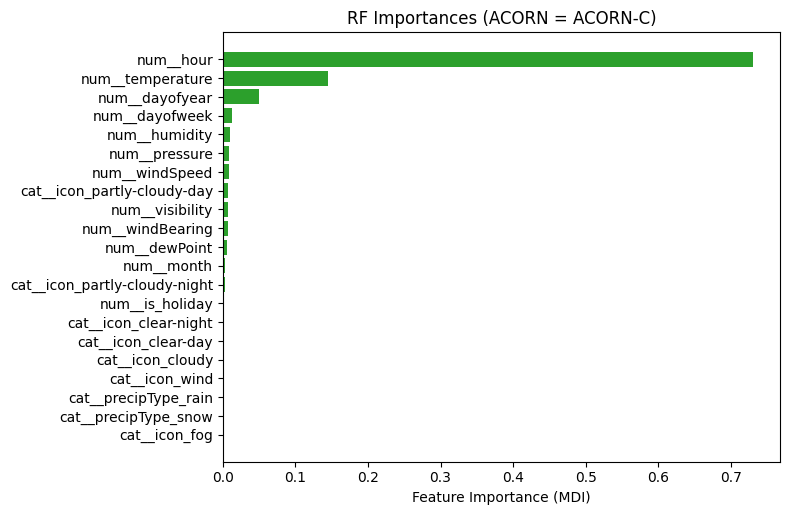

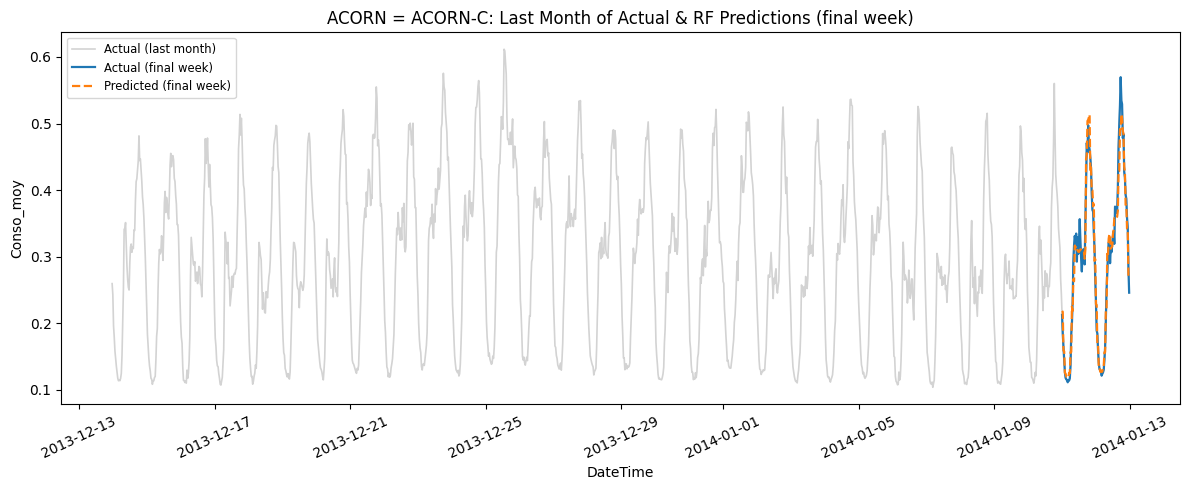


--- Best RF Feature Importances for ACORN = ACORN-F ---
  Top 10 features by importance:
    num__hour                       0.7134
    num__temperature                0.1897
    num__dayofyear                  0.0523
    num__dayofweek                  0.0192
    num__month                      0.0040
    num__windSpeed                  0.0032
    num__humidity                   0.0032
    num__dewPoint                   0.0029
    num__pressure                   0.0029
    num__visibility                 0.0025


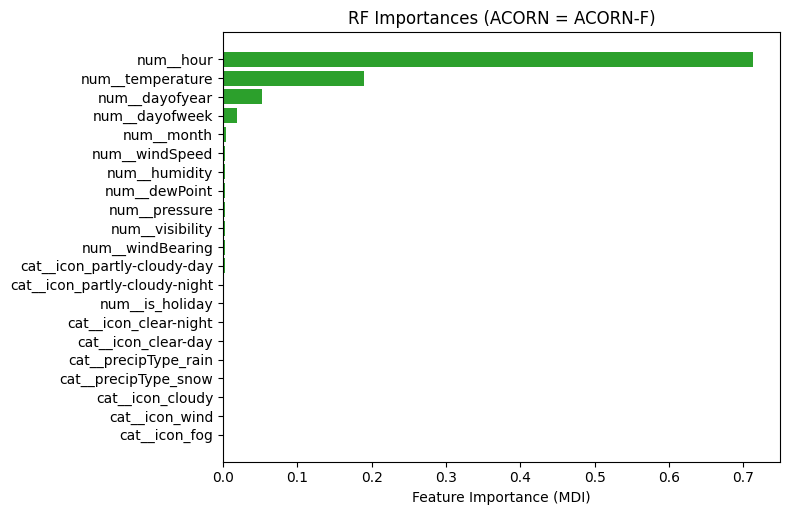

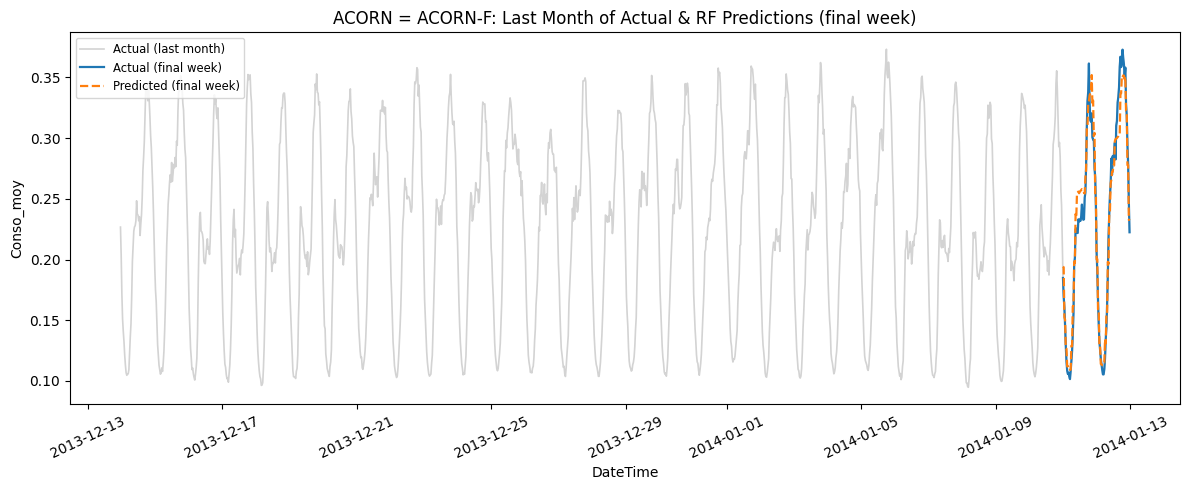


--- Best RF Feature Importances for ACORN = ACORN-P ---
  Top 10 features by importance:
    num__hour                       0.5730
    num__temperature                0.0777
    num__dayofyear                  0.0640
    num__dewPoint                   0.0564
    num__month                      0.0441
    num__pressure                   0.0269
    num__visibility                 0.0254
    num__windSpeed                  0.0237
    num__windBearing                0.0226
    num__humidity                   0.0195


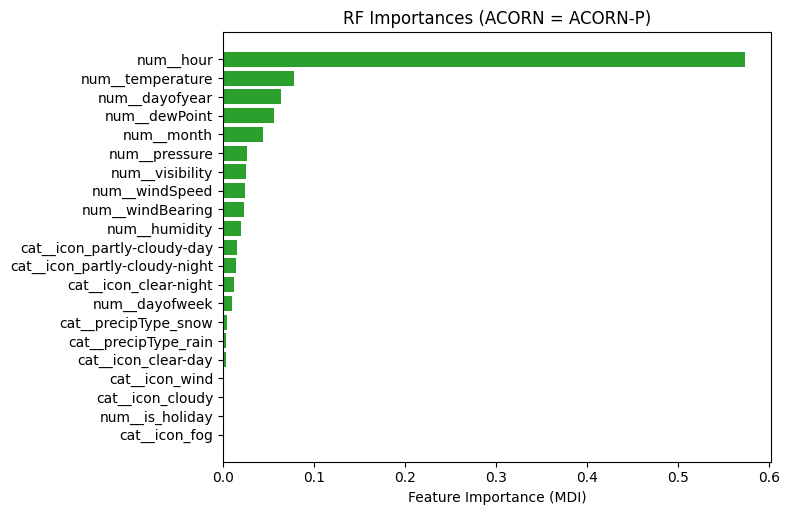

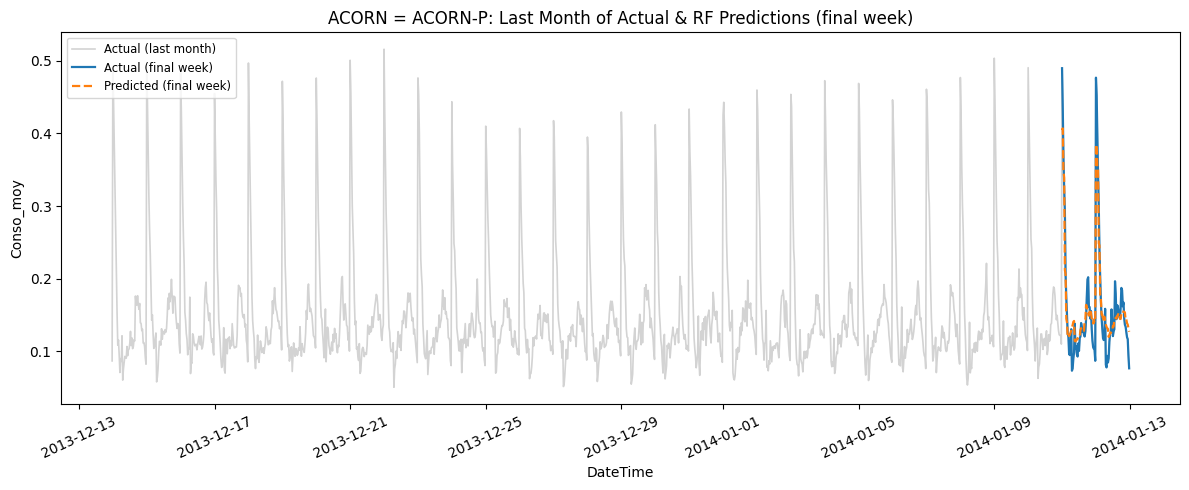

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# FEATURE IMPORTANCE AND PLOTTING LAST MONTH PER ACORN
# ──────────────────────────────────────────────────────────────────────────────
for acorn_label, info in results_rf.items():
    # FEATURE IMPORTANCE
    print(f"\n--- Best RF Feature Importances for ACORN = {acorn_label} ---")
    pipe    = info["pipeline"]
    preproc = pipe.named_steps["preproc"]
    rf_mod  = pipe.named_steps["rf"]
    
    # 6 Retrieve post‐transform feature names
    feature_names = preproc.get_feature_names_out()
    importances   = rf_mod.feature_importances_
    idx_sorted    = np.argsort(importances)[::-1]
    
    print("  Top 10 features by importance:")
    for i in idx_sorted[:10]:
        print(f"    {feature_names[i]:<30}  {importances[i]:0.4f}")
    
    # Plot all importances
    n_features = len(feature_names)
    plt.figure(figsize=(8, n_features * 0.25))
    plt.barh(
        np.arange(n_features),
        importances[idx_sorted],
        align="center",
        color="C2"
    )
    plt.yticks(np.arange(n_features), feature_names[idx_sorted])
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance (MDI)")
    plt.title(f"RF Importances (ACORN = {acorn_label})")
    plt.tight_layout()
    plt.show()
    
    # PLOT LAST MONTH WITH FINAL WEEK’S PREDICTIONS
    full_group    = df[df["Acorn"] == acorn_label].sort_values("DateTime").reset_index(drop=True)
    last_timestamp = full_group["DateTime"].max()
    one_month_ago  = last_timestamp - pd.Timedelta(days=30)
    last_month_df  = full_group[full_group["DateTime"] >= one_month_ago].reset_index(drop=True)
    
    sub_test = info["df_test_sub"].sort_values("DateTime").reset_index(drop=True)
    y_pred   = info["y_pred_sub"]
    
    plt.figure(figsize=(12, 5))
    # Actual last month (light gray)
    plt.plot(
        last_month_df["DateTime"],
        last_month_df["Conso_moy"],
        label="Actual (last month)",
        color="lightgray",
        linewidth=1.2
    )
    # Actual final week (solid blue)
    plt.plot(
        sub_test["DateTime"],
        sub_test["Conso_moy"],
        label="Actual (final week)",
        color="C0",
        linewidth=1.6
    )
    # Predicted final week (dashed orange)
    plt.plot(
        sub_test["DateTime"],
        y_pred,
        label="Predicted (final week)",
        color="C1",
        linestyle="--",
        linewidth=1.6
    )
    plt.xlabel("DateTime")
    plt.ylabel("Conso_moy")
    plt.title(f"ACORN = {acorn_label}: Last Month of Actual & RF Predictions (final week)")
    plt.legend(loc="upper left", fontsize="small")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

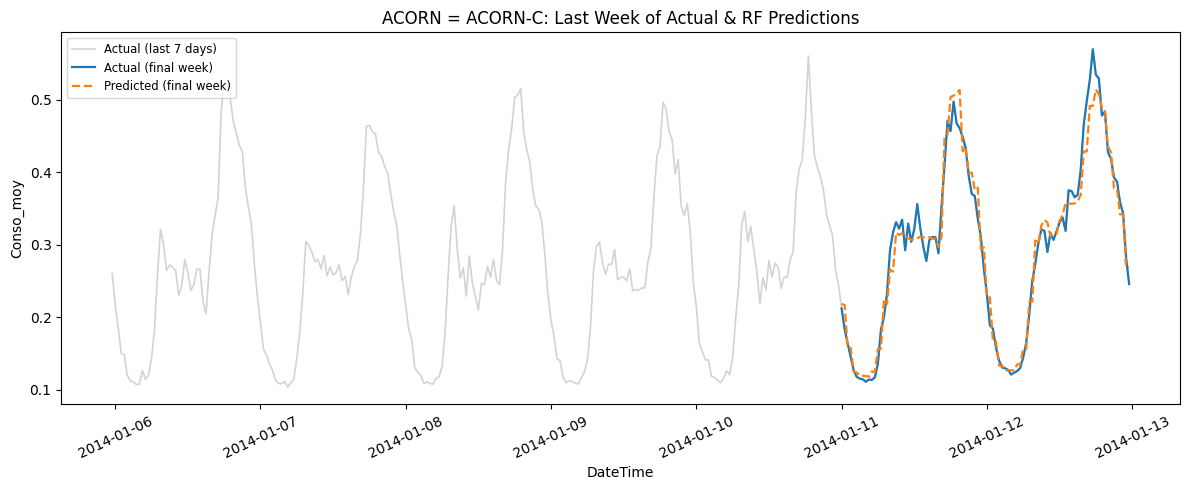

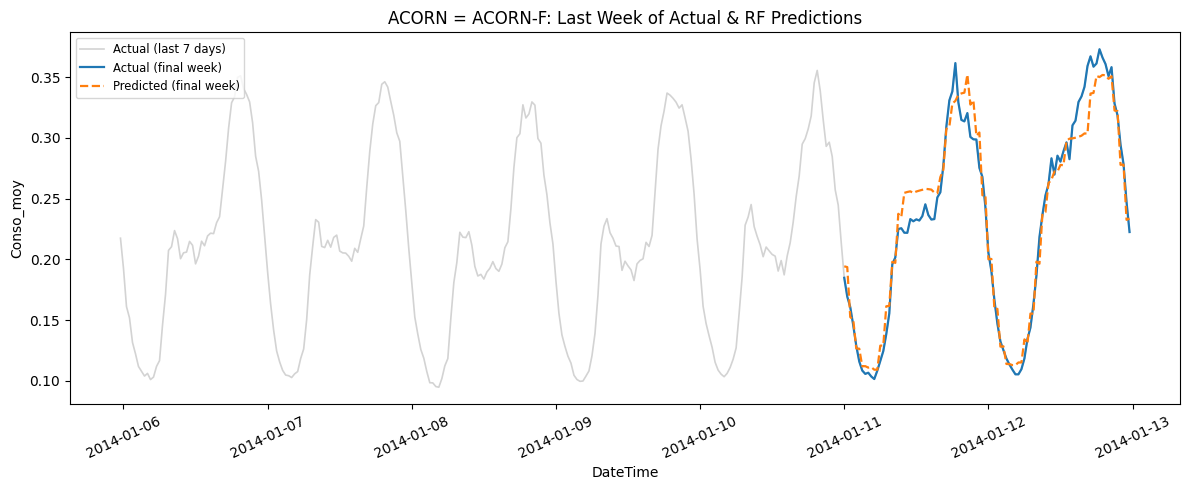

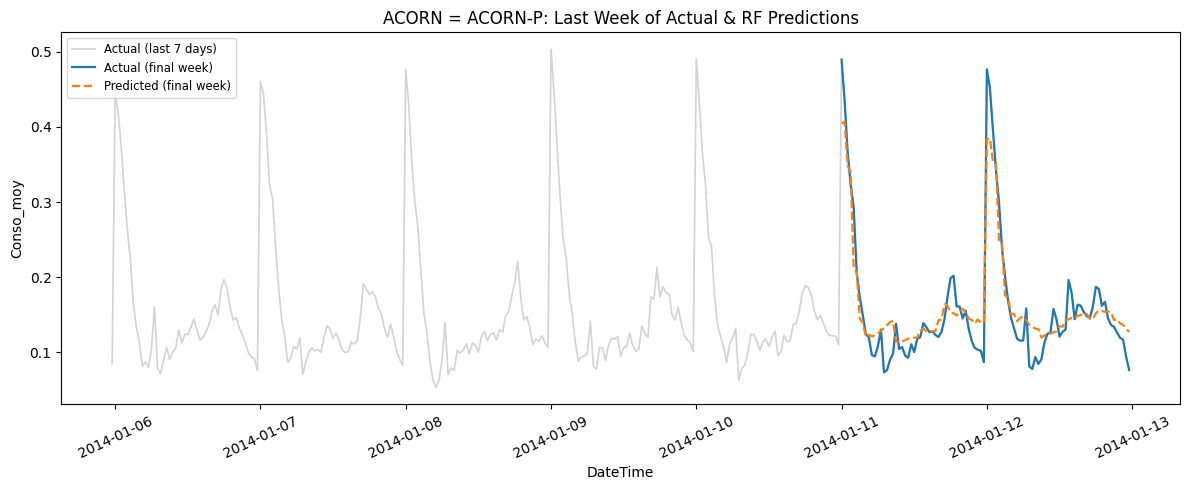

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# Plot only the last week of actual consumption and overlay the final week’s RF predictions
# ──────────────────────────────────────────────────────────────────────────────

for acorn_label, info in results_rf.items():
    # Full history for this ACORN, sorted by DateTime
    full_group     = df[df["Acorn"] == acorn_label].sort_values("DateTime").reset_index(drop=True)
    last_timestamp = full_group["DateTime"].max()
    
    # Compute one week ago
    one_week_ago = last_timestamp - pd.Timedelta(days=7)
    
    # Filter to only the last 7 days of actual consumption
    last_week_df = full_group[full_group["DateTime"] >= one_week_ago].reset_index(drop=True)
    
    # Extract the final week test subset and its predictions
    sub_test = info["df_test_sub"].sort_values("DateTime").reset_index(drop=True)
    y_pred   = info["y_pred_sub"]
    
    # Plot
    plt.figure(figsize=(12, 5))
    
    # Last 7 days actual (light gray)
    plt.plot(
        last_week_df["DateTime"],
        last_week_df["Conso_moy"],
        label="Actual (last 7 days)",
        color="lightgray",
        linewidth=1.2
    )
    
    # Actual final week (solid blue) – these 7 days include the last week
    plt.plot(
        sub_test["DateTime"],
        sub_test["Conso_moy"],
        label="Actual (final week)",
        color="C0",
        linewidth=1.6
    )
    
    # RF predicted final week (dashed orange)
    plt.plot(
        sub_test["DateTime"],
        y_pred,
        label="Predicted (final week)",
        color="C1",
        linestyle="--",
        linewidth=1.6
    )
    
    plt.xlabel("DateTime")
    plt.ylabel("Conso_moy")
    plt.title(f"ACORN = {acorn_label}: Last Week of Actual & RF Predictions")
    plt.legend(loc="upper left", fontsize="small")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()


In [22]:
pred_cons = pd.read_parquet(r'..\data\02_processed\parquet\group_4_half_hourly_predict.parquet')

In [23]:
pred_df = create_features(df_weather_hourly, pred_cons)


In [24]:
for acorn_label in pred_df.Acorn.unique():
    pred_acorn = pred_df[pred_df.Acorn == acorn_label].sort_values(by='DateTime').drop(columns='DateTime')
    pred_acorn = pred_acorn.drop(columns=['Acorn','day_of_week', 'Conso_moy_predict'])
    indexes = pred_cons[pred_cons.Acorn == acorn_label].index
    pred_cons.loc[indexes, 'Conso_moy_predict'] = results_rf[acorn_label]['pipeline'].predict(pred_acorn)

In [25]:
pred_cons.to_parquet(r'..\data\02_processed\parquet\group_4_half_hourly_predict_rf.parquet', index=False)

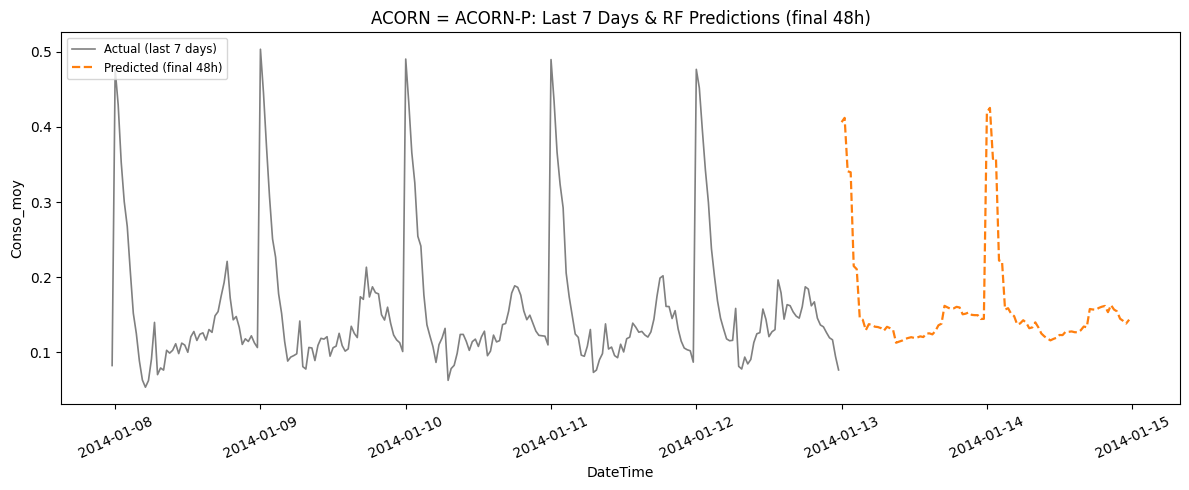

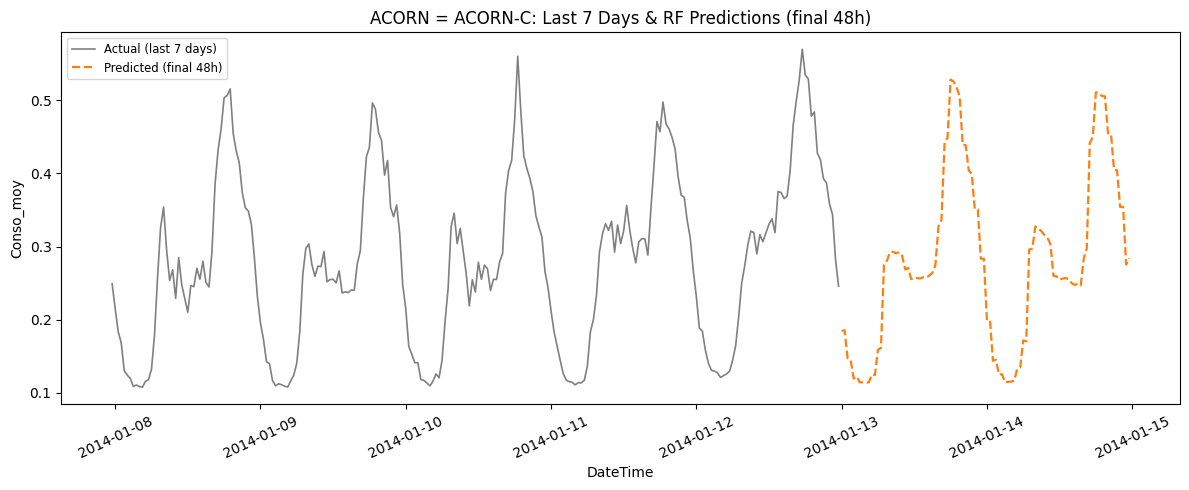

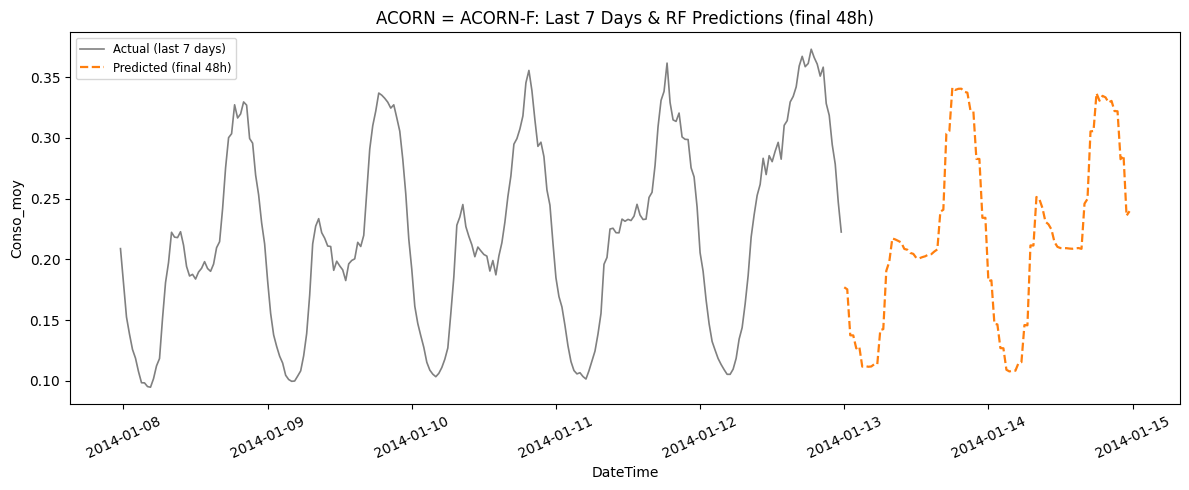

In [ ]:
# PLOT LAST 7 DAYS WITH FINAL 48h PREDICTIONS
for acorn_label in pred_df.Acorn.unique():
    full_group    = df[df["Acorn"] == acorn_label].sort_values("DateTime").reset_index(drop=True)
    last_timestamp = pred_df["DateTime"].max()
    one_week_ago   = last_timestamp - pd.Timedelta(days=7)
    last_week_df   = full_group[full_group["DateTime"] >= one_week_ago].reset_index(drop=True)
    
    plt.figure(figsize=(12, 5))
    # Actual last 7 days (gray)
    plt.plot(
        last_week_df["DateTime"],
        last_week_df["Conso_moy"],
        label="Actual (last 7 days)",
        color="gray",
        linewidth=1.2
    )
    # Actual final 48h (blue)
    # Predicted final 48h (dashed orange)
    plt.plot(
        pred_cons[pred_cons.Acorn == acorn_label]["DateTime"],
        pred_cons[pred_cons.Acorn == acorn_label]["Conso_moy_predict"],
        label="Predicted (final 48h)",
        color="C1",
        linestyle="--",
        linewidth=1.6
    )
    plt.xlabel("DateTime")
    plt.ylabel("Conso_moy")
    plt.title(f"ACORN = {acorn_label}: Last 7 Days & RF Predictions (final 48h)")
    plt.legend(loc="upper left", fontsize="small")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

In [27]:
import joblib
for acorn_label in pred_df.Acorn.unique():
    joblib.dump(results_rf[acorn_label]['pipeline'],r'..\models\r'+f'andom_forest_{acorn_label}.pkl')